
🚀 LightGBM STANDALONE: Performance Analysis

📊 Configuration:
  Chunk size: 50,000
  Sample rate: 1.0
  Sequence window: 10
  LightGBM estimators: 200
  LightGBM device: CPU (multi-core)

[1/4] EFFICIENT DATA LOADING
----------------------------------------

📁 Preprocessed file not found. Creating it from dataset/augmented_data.csv...
Total rows: 1,007,460
Using full dataset: 1,007,460 rows

[2/4] OPTIMIZED FEATURE ENGINEERING
----------------------------------------
⚡ Processing data in parallel chunks...


Processing chunks: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02s/it]


💾 Saving preprocessed data to preprocessed_data_optimized_light.npz...
💾 Loading preprocessed data from preprocessed_data_optimized_light.npz...
✓ Loaded data. Features shape: (1007460, 23), Labels shape: (1007460,)

[3/4] DATA SPLITTING & LIGHTGBM TRAINING
----------------------------------------
Training features shape: (705222, 23)
Test features shape: (302238, 23)
Training LightGBM...
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.0034592
[200]	valid_0's binary_logloss: 0.000689567
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.000689567
✓ LightGBM training complete in 15.8 seconds
  Best iteration: 200

[4/4] MODEL EVALUATION
----------------------------------------
LightGBM Standalone Metrics:
  Accuracy:  0.9999
  Precision: 0.9998
  Recall:    0.9997
  F1 Score:  0.9997
  ROC AUC:   1.0000

📊 Confusion Matrix:
[[252157     11]
 [    15  50055]]

📋 Detailed Classification Report:
              pre

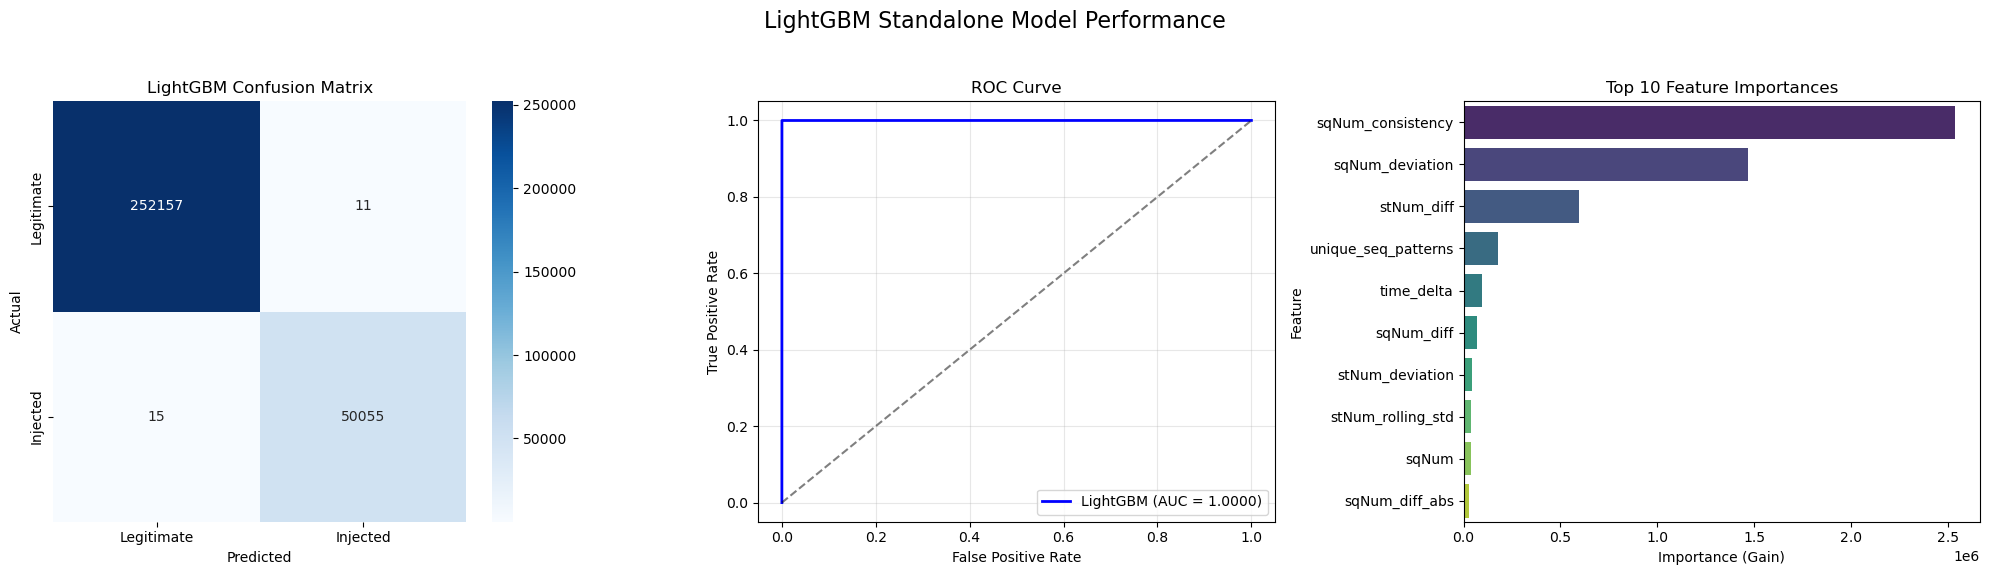


💾 Saving model...
✓ Model saved to lightgbm_only_model.joblib

✅ LightGBM STANDALONE ANALYSIS COMPLETE!


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, precision_score, recall_score, f1_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import warnings
import gc
import os
from tqdm import tqdm
import lightgbm as lgb
import joblib
import time

warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("🚀 LightGBM STANDALONE: Performance Analysis")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================

# Data processing configuration
CHUNK_SIZE = 50000
SAMPLE_RATE = 1.0
SEQUENCE_WINDOW = 10

# LightGBM configuration
LGBM_PARAMS = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'device': 'cpu',  # Using CPU for wider compatibility
    'seed': 42,
    'force_col_wise': True
}
N_ESTIMATORS = 200
RANDOM_STATE = 42

print("\n📊 Configuration:")
print(f"  Chunk size: {CHUNK_SIZE:,}")
print(f"  Sample rate: {SAMPLE_RATE}")
print(f"  Sequence window: {SEQUENCE_WINDOW}")
print(f"  LightGBM estimators: {N_ESTIMATORS}")
print(f"  LightGBM device: CPU (multi-core)")

# ===========================
# EFFICIENT DATA LOADING
# ===========================

print("\n[1/4] EFFICIENT DATA LOADING")
print("-" * 40)

file_path = "dataset/augmented_data.csv"
preprocessed_file = 'preprocessed_data_optimized_light.npz'

# Check if preprocessed file exists, otherwise create it
if not os.path.exists(preprocessed_file):
    print(f"\n📁 Preprocessed file not found. Creating it from {file_path}...")
    
    # Fast row counting
    def count_rows_efficiently(filename):
        count = 0
        with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
            for _ in f:
                count += 1
        return count - 1

    total_rows = count_rows_efficiently(file_path)
    print(f"Total rows: {total_rows:,}")
    
    if SAMPLE_RATE < 1.0:
        rows_to_use = int(total_rows * SAMPLE_RATE)
        print(f"Sampling {SAMPLE_RATE*100:.0f}% of data: {rows_to_use:,} rows")
    else:
        rows_to_use = total_rows
        print(f"Using full dataset: {rows_to_use:,} rows")

    # ===========================
    # OPTIMIZED FEATURE ENGINEERING
    # ===========================
    print("\n[2/4] OPTIMIZED FEATURE ENGINEERING")
    print("-" * 40)

    def encode_allData(x):
        try:
            if isinstance(x, str):
                x = x.replace("'", '"')
                data = ast.literal_eval(x) if x.startswith('[') else json.loads(x)
                if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict) and 'boolean' in data[0]:
                    return 1 if data[0]['boolean'] else 0
            x_str = str(x).lower()
            return 1 if 'true' in x_str else 0
        except:
            return 1 if 'true' in str(x).lower() else 0

    def parse_time_string(time_str):
        try:
            parts = str(time_str).split(':')
            return int(parts[0]) * 60 + float(parts[1]) if len(parts) == 2 else 0
        except:
            return 0

    def calculate_sequence_features_optimized(df, window_size=SEQUENCE_WINDOW):
        features = df.copy()
        
        # Calculate differences using pandas Series to preserve DataFrame structure
        features['sqNum_diff'] = features['sqNum'].diff().fillna(0)
        features['stNum_diff'] = features['stNum'].diff().fillna(0)
        features['sqNum_diff_abs'] = features['sqNum_diff'].abs()
        features['stNum_diff_abs'] = features['stNum_diff'].abs()
        
        # Jump detection
        features['sqNum_jump'] = (features['sqNum_diff_abs'] > 1).astype(int)
        features['stNum_jump'] = (features['stNum_diff_abs'] > 1).astype(int)
        
        # Rolling statistics
        for col in ['sqNum', 'stNum']:
            features[f'{col}_rolling_mean'] = features[col].rolling(window=window_size, min_periods=1).mean()
            features[f'{col}_rolling_std'] = features[col].rolling(window=window_size, min_periods=1).std().fillna(0)
            features[f'{col}_rolling_median'] = features[col].rolling(window=window_size, min_periods=1).median()
            features[f'{col}_deviation'] = np.abs(features[col] - features[f'{col}_rolling_median'])
        
        # Pattern uniqueness
        features['unique_seq_patterns'] = features['sqNum_diff_abs'].rolling(window=window_size, min_periods=1).std().fillna(0)
        features['unique_state_patterns'] = features['stNum_diff_abs'].rolling(window=window_size, min_periods=1).std().fillna(0)
        
        # Consistency measures - now using DataFrame columns instead of numpy arrays
        features['sqNum_consistency'] = (features['sqNum_diff'] == 1).astype(float).rolling(window=window_size, min_periods=1).mean().fillna(1.0)
        features['stNum_consistency'] = (features['stNum_diff'] == 1).astype(float).rolling(window=window_size, min_periods=1).mean().fillna(1.0)
        
        # Time delta z-score
        time_delta = features['time_delta'].values
        time_delta_clean = np.where(np.isfinite(time_delta), time_delta, 0)
        if np.std(time_delta_clean) > 0:
            features['time_delta_zscore'] = np.abs(stats.zscore(time_delta_clean))
        else:
            features['time_delta_zscore'] = 0
        
        return features

    print("⚡ Processing data in parallel chunks...")
    columns_to_read = ['allData', 'sqNum', 'stNum', 'timestamp', 'label']
    
    def process_chunk(chunk_data):
        chunk, last_tail = (chunk_data[0], chunk_data[1] if len(chunk_data) > 1 else None)
        chunk['allData'] = chunk['allData'].apply(encode_allData)
        chunk['timestamp_seconds'] = chunk['timestamp'].apply(parse_time_string)
        chunk['time_delta'] = chunk['timestamp_seconds'].diff().fillna(0).clip(lower=0)
        
        if last_tail is not None: 
            chunk = pd.concat([last_tail, chunk], ignore_index=True)
        
        chunk = calculate_sequence_features_optimized(chunk)
        
        if last_tail is not None: 
            chunk = chunk.iloc[len(last_tail):]
        
        feature_cols = [
            'allData', 'sqNum', 'stNum', 'time_delta', 'sqNum_diff', 'sqNum_diff_abs', 'sqNum_jump',
            'stNum_diff', 'stNum_diff_abs', 'stNum_jump', 'sqNum_rolling_mean', 'sqNum_rolling_std',
            'sqNum_rolling_median', 'stNum_rolling_mean', 'stNum_rolling_std', 'stNum_rolling_median',
            'unique_seq_patterns', 'unique_state_patterns', 'sqNum_consistency', 'stNum_consistency',
            'sqNum_deviation', 'stNum_deviation', 'time_delta_zscore'
        ]
        
        chunk[feature_cols] = chunk[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
        return chunk[feature_cols].values, chunk['label'].values, chunk.tail(SEQUENCE_WINDOW)
    
    skip_rows = sorted(np.random.choice(range(1, total_rows + 1), size=int(total_rows * (1 - SAMPLE_RATE)), replace=False)) if SAMPLE_RATE < 1.0 else None
    chunk_iterator = pd.read_csv(file_path, chunksize=CHUNK_SIZE, usecols=columns_to_read, skiprows=skip_rows)
    
    all_features_list, all_labels_list, last_chunk_tail = [], [], None
    total_chunks = (rows_to_use // CHUNK_SIZE) + 1
    
    for chunk in tqdm(chunk_iterator, total=total_chunks, desc="Processing chunks"):
        features, labels, tail = process_chunk([chunk, last_chunk_tail])
        all_features_list.append(features)
        all_labels_list.append(labels)
        last_chunk_tail = tail
        gc.collect()
        
    all_features, all_labels = np.vstack(all_features_list), np.concatenate(all_labels_list)
    feature_cols = [
        'allData', 'sqNum', 'stNum', 'time_delta', 'sqNum_diff', 'sqNum_diff_abs', 'sqNum_jump',
        'stNum_diff', 'stNum_diff_abs', 'stNum_jump', 'sqNum_rolling_mean', 'sqNum_rolling_std',
        'sqNum_rolling_median', 'stNum_rolling_mean', 'stNum_rolling_std', 'stNum_rolling_median',
        'unique_seq_patterns', 'unique_state_patterns', 'sqNum_consistency', 'stNum_consistency',
        'sqNum_deviation', 'stNum_deviation', 'time_delta_zscore'
    ]
    
    print(f"💾 Saving preprocessed data to {preprocessed_file}...")
    np.savez_compressed(preprocessed_file, features=all_features, feature_names=np.array(feature_cols), labels=all_labels)

# Load the data
print(f"💾 Loading preprocessed data from {preprocessed_file}...")
data = np.load(preprocessed_file, allow_pickle=True)
all_features = data['features']
feature_cols = list(data['feature_names'])
all_labels = data['labels']
print(f"✓ Loaded data. Features shape: {all_features.shape}, Labels shape: {all_labels.shape}")

# ===========================
# DATA SPLITTING & TRAINING
# ===========================

print("\n[3/4] DATA SPLITTING & LIGHTGBM TRAINING")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.3, random_state=RANDOM_STATE, stratify=all_labels
)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training LightGBM...")

start_time = time.time()
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lgbm_model = lgb.train(
    LGBM_PARAMS,
    train_data,
    num_boost_round=N_ESTIMATORS,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(100)]
)

elapsed = time.time() - start_time
print(f"✓ LightGBM training complete in {elapsed:.1f} seconds")
print(f"  Best iteration: {lgbm_model.best_iteration}")

# ===========================
# MODEL EVALUATION
# ===========================

print("\n[4/4] MODEL EVALUATION")
print("-" * 40)

lgbm_pred_proba = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)
lgbm_pred = (lgbm_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, lgbm_pred)
precision = precision_score(y_test, lgbm_pred, zero_division=0)
recall = recall_score(y_test, lgbm_pred, zero_division=0)
f1 = f1_score(y_test, lgbm_pred, zero_division=0)
fpr, tpr, _ = roc_curve(y_test, lgbm_pred_proba)
roc_auc = auc(fpr, tpr)

print("LightGBM Standalone Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC AUC:   {roc_auc:.4f}")

cm = confusion_matrix(y_test, lgbm_pred)
print("\n📊 Confusion Matrix:")
print(cm)

print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, lgbm_pred, target_names=["Legitimate", "Injected"], zero_division=0))

# ===========================
# VISUALIZATION & SAVING
# ===========================

print("\n[5/5] VISUALIZATION & SAVING")
print("-" * 40)

# Feature importance
feature_importance = lgbm_model.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
print("🔍 Top 10 Most Important Features:")
print(importance_df.head(10))

# Plotting
print("📈 Generating visualizations...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=["Legitimate", "Injected"], yticklabels=["Legitimate", "Injected"])
axes[0].set_title('LightGBM Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. ROC Curve
axes[1].plot(fpr, tpr, 'b-', label=f'LightGBM (AUC = {roc_auc:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Feature Importance
top_features = importance_df.head(10)
sns.barplot(x='importance', y='feature', data=top_features, ax=axes[2], palette='viridis')
axes[2].set_title('Top 10 Feature Importances')
axes[2].set_xlabel('Importance (Gain)')
axes[2].set_ylabel('Feature')

plt.suptitle('LightGBM Standalone Model Performance', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('lightgbm_only_results.png', dpi=150)
plt.show()

# Save model
print("\n💾 Saving model...")
model_package = {
    'lgbm': lgbm_model,
    'feature_names': feature_cols,
}
model_filename = 'lightgbm_only_model.joblib'
joblib.dump(model_package, model_filename)
print(f"✓ Model saved to {model_filename}")

print("\n" + "="*60)
print("✅ LightGBM STANDALONE ANALYSIS COMPLETE!")
print("="*60)


🚀 LightGBM IDS — Robust Features + Monotone Constraints

📊 Configuration
  Chunk size        : 50,000
  Sample rate       : 1.0
  Window size       : 10
  Estimators        : 400
  Data file         : dataset/augmented_data.csv
  Output NPZ        : preprocessed_idsv2.npz
  Splits            : TEST=0.3, VAL(of train)=0.2
  Threshold policy  : target_recall

[1/6] PREPROCESSING (chunked)
----------------------------------------
Detected columns → cmd: allData | publisher: —
Rows (total)      : 1,007,460
Rows (used)       : 1,007,460
🔁 Using cached preprocessed file: preprocessed_idsv2.npz

[2/6] LOAD PREPROCESSED
----------------------------------------
✓ Features: (1007460, 30), Labels: (1007460,), Publishers: 1007460

[3/6] SPLIT + LEARN TIMING GUARDS (from TRAIN normals only)
----------------------------------------
✓ Train=(564177, 36) | Val=(141045, 36) | Test=(302238, 36)
✓ Global Δt guard ms range (TRAIN normals): [300.0, 5000.0]

[4/6] TRAIN LIGHTGBM (monotone constraints, imba

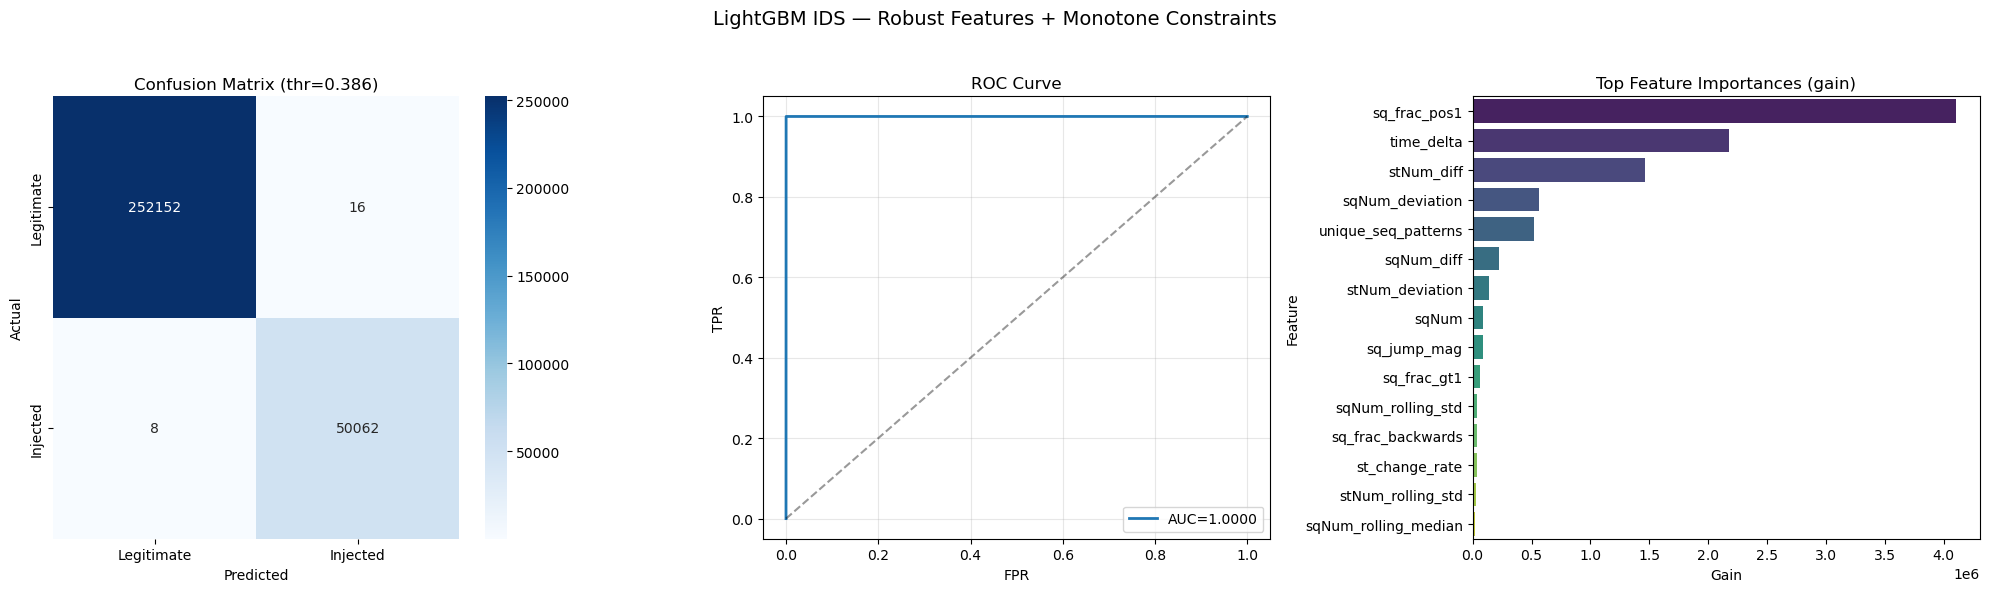


💾 Saving model package...
✓ Saved → ids_lgbm_model.joblib

✅ DONE — Model trained, policy threshold selected, package saved

🔴 Example (injected-side view) — prev→curr

🧩 CORE FIELDS (prev → curr)
• sqNum: 57 → 43 (Δ=-14)
• stNum: 577 → 578 (Δ=1)
• Δt   : 2.600 s
• heartbeat guard: 300–5000 ms | dt_in_baseline=1 | dt_in_pub=0
• flags: sq_backwards=1, sq_jump>1=0, st_change_with_cmd=0, st_change_without_cmd=1

🟢 Example (legitimate-side view) — prev→curr

🧩 CORE FIELDS (prev → curr)
• sqNum: 52 → 53 (Δ=1)
• stNum: 618 → 618 (Δ=0)
• Δt   : 4.900 s
• heartbeat guard: 300–5000 ms | dt_in_baseline=1 | dt_in_pub=0
• flags: sq_backwards=0, sq_jump>1=0, st_change_with_cmd=0, st_change_without_cmd=0


In [4]:
# ============================================================
# 🚀 LightGBM IDS — Robust Features + Monotone Constraints
#     (NO test leakage, imbalance-aware, policy-driven threshold)
#     + prev→curr operator explainer
# ============================================================

import os, gc, ast, json, time, warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    classification_report, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings("ignore")

print("\n" + "="*60)
print("🚀 LightGBM IDS — Robust Features + Monotone Constraints")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================
CHUNK_SIZE       = 50_000
SAMPLE_RATE      = 1.0
WINDOW           = 10           # rolling/window size
DATA_CSV         = "dataset/augmented_data.csv"
NPZ_FILE         = "preprocessed_idsv2.npz"
RANDOM_STATE     = 42
TEST_SIZE        = 0.30
VAL_SIZE         = 0.20         # of TRAIN
N_ESTIMATORS     = 400

# ---- Threshold policy (pick operating point on VALIDATION) ----
# Options: "f1" | "target_recall" | "max_fpr" | "cost"
OP_MODE              = "target_recall"
TARGET_RECALL        = 0.9998         # for OP_MODE="target_recall"
MAX_FPR_PER_MILLION  = 80             # for OP_MODE="max_fpr" (FP per 1e6 negatives)
COST_FP              = 1.0            # for OP_MODE="cost"
COST_FN              = 5.0            # for OP_MODE="cost"

LGBM_PARAMS = dict(
    objective="binary",
    metric="binary_logloss",
    boosting_type="gbdt",
    num_leaves=63,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    num_threads=-1,
    device="cpu",
    seed=RANDOM_STATE,
    force_col_wise=True,
)

print("\n📊 Configuration")
print(f"  Chunk size        : {CHUNK_SIZE:,}")
print(f"  Sample rate       : {SAMPLE_RATE}")
print(f"  Window size       : {WINDOW}")
print(f"  Estimators        : {N_ESTIMATORS}")
print(f"  Data file         : {DATA_CSV}")
print(f"  Output NPZ        : {NPZ_FILE}")
print(f"  Splits            : TEST={TEST_SIZE}, VAL(of train)={VAL_SIZE}")
print(f"  Threshold policy  : {OP_MODE}")

# ===========================
# HELPERS
# ===========================
CMD_ALIASES = ["cmd","command","cmd_bool","cmd_bit","command_bit","bitstring_ones","allData"]
PUB_ALIASES = ["publisher_id","publisher","AppID","app_id","gocbRef","goose_id"]

def detect_columns(csv_path):
    cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
    has_cmd = next((c for c in CMD_ALIASES if c in cols), None)
    has_pub = next((c for c in PUB_ALIASES if c in cols), None)
    for n in ["sqNum","stNum","timestamp","label"]:
        if n not in cols:
            raise ValueError(f"Required column '{n}' not found in CSV.")
    return has_cmd, has_pub

def encode_booleanish(x):
    try:
        if isinstance(x, str):
            xs = x.replace("'", '"').strip()
            if xs.startswith("["):
                v = ast.literal_eval(xs)
                if isinstance(v, list) and v and isinstance(v[0], dict) and "boolean" in v[0]:
                    return 1 if v[0]["boolean"] else 0
            try:
                v = json.loads(xs)
                if isinstance(v, bool): return 1 if v else 0
            except: pass
            xs_low = xs.lower()
            if "true" in xs_low: return 1
            if "false" in xs_low: return 0
    except: pass
    if isinstance(x, (int,float)): return 1 if x!=0 else 0
    return 1 if str(x).strip().lower() in {"1","true","t","yes","y"} else 0

def parse_time_seconds(time_str):
    try:
        s = str(time_str)
        if ":" in s:
            m, sec = s.split(":")
            return int(m)*60.0 + float(sec)
        return float(s)
    except:
        return 0.0

def count_rows_fast(path):
    cnt=0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in f: cnt+=1
    return max(0, cnt-1)

# ===========================
# PREPROCESS (chunked)
# ===========================
print("\n[1/6] PREPROCESSING (chunked)")
print("-"*40)

cmd_col, pub_col = detect_columns(DATA_CSV)
print(f"Detected columns → cmd: {cmd_col or '—'} | publisher: {pub_col or '—'}")

total_rows = count_rows_fast(DATA_CSV)
use_rows = int(total_rows * SAMPLE_RATE)
print(f"Rows (total)      : {total_rows:,}")
print(f"Rows (used)       : {use_rows:,}")

if not os.path.exists(NPZ_FILE):
    base_cols = ["sqNum","stNum","timestamp","label"]
    read_cols = base_cols + ([cmd_col] if cmd_col else []) + ([pub_col] if pub_col else [])
    skiprows = (sorted(np.random.choice(range(1,total_rows+1), size=int(total_rows*(1-SAMPLE_RATE)), replace=False))
                if SAMPLE_RATE<1.0 else None)

    def calc_features(df: pd.DataFrame, window=WINDOW):
        out = df.copy()
        if cmd_col and cmd_col in out.columns and "cmd" not in out.columns:
            out = out.rename(columns={cmd_col:"cmd"})
        if pub_col and pub_col in out.columns and "publisher_id" not in out.columns:
            out = out.rename(columns={pub_col:"publisher_id"})

        for c in ["sqNum","stNum"]:
            out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0).astype(int)

        out["t_sec"] = out["timestamp"].apply(parse_time_seconds)
        out["time_delta"] = out["t_sec"].diff().fillna(0).clip(lower=0)

        out["sqNum_diff"] = out["sqNum"].diff().fillna(0)
        out["stNum_diff"] = out["stNum"].diff().fillna(0)
        out["sqNum_diff_abs"] = out["sqNum_diff"].abs()
        out["stNum_diff_abs"] = out["stNum_diff"].abs()

        out["sq_backwards_flag"] = (out["sqNum_diff"] < 0).astype(int)
        out["sq_jump_gt1_flag"]  = (out["sqNum_diff"] > 1).astype(int)
        out["sq_jump_mag"]       = out["sqNum_diff"].abs()
        out["st_change_flag"]    = (out["stNum_diff"] != 0).astype(int)

        if "cmd" in out.columns:
            out["cmd"] = out["cmd"].apply(encode_booleanish)
            out["st_change_with_cmd_flag"]    = ((out["st_change_flag"]==1)&(out["cmd"]==1)).astype(int)
            out["st_change_without_cmd_flag"] = ((out["st_change_flag"]==1)&(out["cmd"]==0)).astype(int)
        else:
            out["st_change_with_cmd_flag"]    = 0
            out["st_change_without_cmd_flag"] = out["st_change_flag"]

        for col in ["sqNum","stNum"]:
            out[f"{col}_rolling_mean"]   = out[col].rolling(window=window, min_periods=1).mean()
            out[f"{col}_rolling_std"]    = out[col].rolling(window=window, min_periods=1).std().fillna(0)
            out[f"{col}_rolling_median"] = out[col].rolling(window=window, min_periods=1).median()
            out[f"{col}_deviation"]      = (out[col]-out[f"{col}_rolling_median"]).abs()

        out["sq_frac_pos1"]       = (out["sqNum_diff"]==1).astype(float).rolling(window=window, min_periods=1).mean()
        out["sq_frac_gt1"]        = (out["sqNum_diff"]>1).astype(float).rolling(window=window, min_periods=1).mean()
        out["sq_frac_backwards"]  = (out["sqNum_diff"]<0).astype(float).rolling(window=window, min_periods=1).mean()
        out["st_change_rate"]     = (out["stNum_diff"]!=0).astype(float).rolling(window=window, min_periods=1).mean()

        out["sqNum_consistency"]  = out["sq_frac_pos1"]
        out["stNum_consistency"]  = (out["stNum_diff"]==1).astype(float).rolling(window=window, min_periods=1).mean()

        out["unique_seq_patterns"]   = out["sqNum_diff_abs"].rolling(window=window, min_periods=1).std().fillna(0)
        out["unique_state_patterns"] = out["stNum_diff_abs"].rolling(window=window, min_periods=1).std().fillna(0)

        td = out["time_delta"].values
        out["time_delta_zscore"] = (np.abs(stats.zscore(td)) if np.std(td)>0 else np.zeros_like(td))

        if "publisher_id" not in out.columns:
            out["publisher_id"] = "unknown"
        else:
            out["publisher_id"] = out["publisher_id"].astype(str)
        return out

    feat_blocks, label_blocks, pub_blocks, last_tail = [], [], [], None
    chunk_iter = pd.read_csv(DATA_CSV, chunksize=CHUNK_SIZE, usecols=read_cols, skiprows=skiprows)
    total_chunks = (use_rows // CHUNK_SIZE) + 1

    for chunk in tqdm(chunk_iter, total=total_chunks, desc="Chunks"):
        if last_tail is not None:
            chunk = pd.concat([last_tail, chunk], ignore_index=True)
        f = calc_features(chunk, window=WINDOW)
        if last_tail is not None:
            f = f.iloc[len(last_tail):].reset_index(drop=True)

        base_feature_cols = [
            "time_delta","time_delta_zscore",
            "sqNum","stNum",
            "sqNum_diff","stNum_diff","sqNum_diff_abs","stNum_diff_abs",
            "sq_backwards_flag","sq_jump_gt1_flag","sq_jump_mag",
            "st_change_flag","st_change_with_cmd_flag","st_change_without_cmd_flag",
            "sqNum_rolling_mean","sqNum_rolling_std","sqNum_rolling_median","sqNum_deviation",
            "stNum_rolling_mean","stNum_rolling_std","stNum_rolling_median","stNum_deviation",
            "sq_frac_pos1","sq_frac_gt1","sq_frac_backwards","st_change_rate",
            "sqNum_consistency","stNum_consistency",
            "unique_seq_patterns","unique_state_patterns",
        ]

        f[base_feature_cols] = f[base_feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0)

        feat_blocks.append(f[base_feature_cols].values)
        label_blocks.append(chunk["label"].values[-len(f):])
        pub_blocks.append(f["publisher_id"].astype(str).values)
        last_tail = chunk.tail(WINDOW).copy()
        gc.collect()

    X_base = np.vstack(feat_blocks)
    y_all  = np.concatenate(label_blocks).astype(int)
    pubs   = np.concatenate(pub_blocks).astype(str)

    print(f"💾 Saving preprocessed arrays → {NPZ_FILE}")
    np.savez_compressed(NPZ_FILE,
                        features=X_base,
                        feature_names=np.array(base_feature_cols, dtype=object),
                        labels=y_all,
                        publisher_id=pubs)
else:
    print(f"🔁 Using cached preprocessed file: {NPZ_FILE}")

# ===========================
# LOAD PREPROCESSED
# ===========================
print("\n[2/6] LOAD PREPROCESSED")
print("-"*40)

npz = np.load(NPZ_FILE, allow_pickle=True)
X_base = np.array(npz["features"])
feat_names = list(npz["feature_names"])
y_all = np.array(npz["labels"]).astype(int)
pubs = np.array(npz["publisher_id"]).astype(str) if "publisher_id" in npz else np.array(["unknown"]*len(y_all))
print(f"✓ Features: {X_base.shape}, Labels: {y_all.shape}, Publishers: {len(pubs)}")

# ===========================
# SPLIT + LEARN TIMING GUARDS (TRAIN normals only)
# ===========================
print("\n[3/6] SPLIT + LEARN TIMING GUARDS (from TRAIN normals only)")
print("-"*40)

X_train_base, X_test_base, y_train_all, y_test, pubs_train_all, pubs_test = train_test_split(
    X_base, y_all, pubs, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
)
X_tr_base, X_val_base, y_tr, y_val, pubs_tr, pubs_val = train_test_split(
    X_train_base, y_train_all, pubs_train_all, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_train_all
)

Xtr = pd.DataFrame(X_tr_base,  columns=feat_names)
Xva = pd.DataFrame(X_val_base, columns=feat_names)
Xte = pd.DataFrame(X_test_base, columns=feat_names)

# Global Δt guard from TRAIN NORMALS
dt_ms_tr = Xtr.loc[y_tr==0, "time_delta"].values * 1000.0
q_lo = float(np.nanquantile(dt_ms_tr, 0.05)) if len(dt_ms_tr) else 1.0
q_hi = float(np.nanquantile(dt_ms_tr, 0.95)) if len(dt_ms_tr) else (q_lo + 1.0)
q_lo = max(0.1, q_lo); q_hi = max(q_lo + 0.1, q_hi)

def add_global_dt_guards(df):
    dt_ms = df["time_delta"].values * 1000.0
    df["dt_in_baseline_flag"]  = ((dt_ms >= q_lo) & (dt_ms <= q_hi)).astype(int)
    df["dt_below_baseline"]    = (dt_ms < q_lo).astype(int)
    df["dt_above_baseline"]    = (dt_ms > q_hi).astype(int)
    return df

Xtr = add_global_dt_guards(Xtr)
Xva = add_global_dt_guards(Xva)
Xte = add_global_dt_guards(Xte)

# Optional per-publisher guards
def add_per_pub(df_in, pubs_vec, ref_df, ref_pubs, ref_y):
    df = df_in.copy()
    dt_ms_ref = ref_df["time_delta"].values * 1000.0
    bounds = {}
    for p in np.unique(ref_pubs):
        m = (ref_pubs==p) & (ref_y==0)
        if m.sum() >= 50:
            vals = dt_ms_ref[m]
            lo = float(np.nanquantile(vals, 0.05))
            hi = float(np.nanquantile(vals, 0.95))
            if hi <= lo: hi = lo + 0.1
            bounds[p] = (lo, hi)
    dt_ms = df["time_delta"].values * 1000.0
    lo_vec = np.full(len(df), q_lo); hi_vec = np.full(len(df), q_hi)
    for i,p in enumerate(pubs_vec):
        if p in bounds: lo_vec[i], hi_vec[i] = bounds[p]
    df["dt_in_pub_baseline_flag"] = ((dt_ms >= lo_vec) & (dt_ms <= hi_vec)).astype(int)
    df["dt_above_pub_baseline"]   = (dt_ms > hi_vec).astype(int)
    df["dt_below_pub_baseline"]   = (dt_ms < lo_vec).astype(int)
    return df

if len(np.unique(pubs_tr)) > 1:
    Xtr = add_per_pub(Xtr, pubs_tr, Xtr, pubs_tr, y_tr)
    Xva = add_per_pub(Xva, pubs_val, Xtr, pubs_tr, y_tr)
    Xte = add_per_pub(Xte, pubs_test, Xtr, pubs_tr, y_tr)
else:
    for df in (Xtr, Xva, Xte):
        df["dt_in_pub_baseline_flag"] = 0
        df["dt_above_pub_baseline"]   = 0
        df["dt_below_pub_baseline"]   = 0

final_feat_names = list(Xtr.columns)
X_train = Xtr.values
X_val   = Xva.values
X_test  = Xte.values

print(f"✓ Train={X_train.shape} | Val={X_val.shape} | Test={X_test.shape}")
print(f"✓ Global Δt guard ms range (TRAIN normals): [{q_lo:.1f}, {q_hi:.1f}]")

# ===========================
# TRAIN (monotone) + imbalance-aware
# ===========================
print("\n[4/6] TRAIN LIGHTGBM (monotone constraints, imbalance-aware)")
print("-"*40)

mono_map = {
    # Good → risk down
    "sq_frac_pos1": -1, "sqNum_consistency": -1, "stNum_consistency": -1,
    "dt_in_baseline_flag": -1, "dt_in_pub_baseline_flag": -1,
    # Bad → risk up
    "sq_backwards_flag": +1, "sq_jump_gt1_flag": +1, "sq_jump_mag": +1,
    "st_change_flag": +1, "st_change_without_cmd_flag": +1,
    "dt_above_baseline": +1, "dt_below_baseline": +1,
    "dt_above_pub_baseline": +1, "dt_below_pub_baseline": +1,
    # Helpful when command exists
    "st_change_with_cmd_flag": -1,
}
monotone_constraints = [mono_map.get(fn, 0) for fn in final_feat_names]
LGBM_PARAMS["monotone_constraints"] = monotone_constraints

pos = max(1, int((y_tr==1).sum())); neg = max(1, int((y_tr==0).sum()))
LGBM_PARAMS["scale_pos_weight"] = neg/pos

print("Monotone constraints summary (name → sign):")
for n,m in zip(final_feat_names, monotone_constraints):
    if m != 0:
        print(f"  {n:28s} -> {m:+d}")
print(f"\nClass weights: scale_pos_weight = {neg}/{pos} = {neg/pos:.3f}")

train_set = lgb.Dataset(X_train, label=y_tr, feature_name=final_feat_names, free_raw_data=False)
valid_set = lgb.Dataset(X_val,   label=y_val, feature_name=final_feat_names, reference=train_set, free_raw_data=False)

start = time.time()
model = lgb.train(
    LGBM_PARAMS,
    train_set,
    num_boost_round=N_ESTIMATORS,
    valid_sets=[valid_set],              # validate on VAL (no test leakage)
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(100)]
)
print(f"✓ Training complete in {time.time()-start:.1f}s | Best iter: {model.best_iteration}")

# ===========================
# THRESHOLD SELECTION (policy-driven) + TEST EVAL
# ===========================
print("\n[5/6] THRESHOLD SELECTION (policy-driven) + EVALUATION (TEST)")
print("-"*40)

def eval_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    acc  = (tp + tn) / max(1, (tn+fp+fn+tp))
    prec = tp / max(1, (tp+fp))
    rec  = tp / max(1, (tp+fn))
    f1   = 0.0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    fpr  = fp / max(1, (fp+tn))
    return dict(thr=thr, tn=tn, fp=fp, fn=fn, tp=tp, acc=acc, prec=prec, rec=rec, f1=f1, fpr=fpr)

def scan_thresholds(y_true, proba, grid=None):
    if grid is None:
        grid = np.unique(np.concatenate([
            np.linspace(0.00, 0.50, 501),
            np.linspace(0.50, 0.99, 100),
            np.array([0.995, 0.9975, 0.999, 0.9995, 1.0])
        ]))
    rows = [eval_at_threshold(y_true, proba, t) for t in grid]
    return pd.DataFrame(rows)

def find_best_threshold_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    thr = np.append(thr, 1.0)
    f1s = (2*prec*rec)/np.clip(prec+rec, 1e-9, None)
    idx = int(np.nanargmax(f1s))
    return float(thr[idx])

# predictions
proba_val  = model.predict(X_val,  num_iteration=model.best_iteration)
proba_test = model.predict(X_test, num_iteration=model.best_iteration)

# policy selection on VALIDATION ONLY
dfv  = scan_thresholds(y_val, proba_val)
thr_f1 = find_best_threshold_f1(y_val, proba_val)

if OP_MODE == "f1":
    chosen_thr = thr_f1

elif OP_MODE == "target_recall":
    # ✅ FIX: choose the LOWEST-FP then LARGEST threshold with recall ≥ target
    cand = dfv[dfv["rec"] >= TARGET_RECALL].copy()
    if len(cand):
        cand.sort_values(["fp","thr"], ascending=[True, False], inplace=True)
        chosen_thr = float(cand.iloc[0]["thr"])
    else:
        # fallback: use F1-best
        chosen_thr = thr_f1

elif OP_MODE == "max_fpr":
    negs = int((y_val == 0).sum())
    max_fp = MAX_FPR_PER_MILLION * max(1, negs) / 1_000_000.0
    cand = dfv[dfv["fp"] <= max_fp].copy()
    if len(cand):
        # among feasible, prefer highest recall, then larger threshold
        cand.sort_values(["rec","thr"], ascending=[False, False], inplace=True)
        chosen_thr = float(cand.iloc[0]["thr"])
    else:
        chosen_thr = thr_f1

elif OP_MODE == "cost":
    cost = COST_FN*dfv["fn"] + COST_FP*dfv["fp"]
    chosen_thr = float(dfv.loc[cost.idxmin(), "thr"])

else:
    raise ValueError(f"Unknown OP_MODE: {OP_MODE}")

def prn(tag, res):
    print(f"{tag:<10} thr={res['thr']:.4f}  Acc={res['acc']:.4f}  Prec={res['prec']:.4f}  Rec={res['rec']:.4f}  F1={res['f1']:.4f}  FPR={res['fpr']:.6f}  CM=[[{res['tn']},{res['fp']}],[{res['fn']},{res['tp']}] ]")

res_050 = eval_at_threshold(y_test, proba_test, 0.50)
res_f1  = eval_at_threshold(y_test, proba_test, thr_f1)
res_ch  = eval_at_threshold(y_test, proba_test, chosen_thr)

print(f"\nPolicy: {OP_MODE}  →  chosen_thr (from VAL) = {chosen_thr:.4f}")
prn("Test@0.50", res_050)
prn("Test@F1  ", res_f1)
prn("Test@OP  ", res_ch)

# For downstream visuals/reporting use chosen OP
tuned_thr = chosen_thr
cm = np.array([[res_ch['tn'], res_ch['fp']], [res_ch['fn'], res_ch['tp']]])

# Also compute ROC/PR on TEST (policy-agnostic)
fpr, tpr, _ = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr)
pr_auc  = average_precision_score(y_test, proba_test)

# ===========================
# VISUALIZATION
# ===========================
print("\n[6/6] VISUALIZATIONS")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=["Legitimate", "Injected"], yticklabels=["Legitimate", "Injected"])
axes[0].set_title(f'Confusion Matrix (thr={tuned_thr:.3f})'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

axes[1].plot(fpr, tpr, label=f'AUC={roc_auc:.4f}', linewidth=2)
axes[1].plot([0,1],[0,1],'k--',alpha=0.4)
axes[1].set_title('ROC Curve'); axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR'); axes[1].legend(); axes[1].grid(alpha=0.3)

imp_gain = model.feature_importance(importance_type='gain')
imp_df = pd.DataFrame({'feature': final_feat_names, 'gain': imp_gain}).sort_values('gain', ascending=False)
sns.barplot(data=imp_df.head(15), x='gain', y='feature', ax=axes[2], palette='viridis')
axes[2].set_title('Top Feature Importances (gain)'); axes[2].set_xlabel('Gain'); axes[2].set_ylabel('Feature')

plt.suptitle('LightGBM IDS — Robust Features + Monotone Constraints', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('ids_lgbm_results.png', dpi=150)
plt.show()

# ===========================
# SAVE MODEL PACKAGE
# ===========================
print("\n💾 Saving model package...")
pkg = {
    "lgbm_model": model,
    "feature_names": final_feat_names,
    "q_lo_ms": q_lo,
    "q_hi_ms": q_hi,
    "monotone_constraints": monotone_constraints,
    "scale_pos_weight": LGBM_PARAMS["scale_pos_weight"],
    "tuned_threshold": float(tuned_thr),
    "op_mode": OP_MODE,
    "op_params": {
        "target_recall": TARGET_RECALL,
        "max_fpr_per_million": MAX_FPR_PER_MILLION,
        "cost_fp": COST_FP,
        "cost_fn": COST_FN
    },
    "roc_auc_test": float(roc_auc),
    "pr_auc_test": float(pr_auc),
}
joblib.dump(pkg, "ids_lgbm_model.joblib")
print("✓ Saved → ids_lgbm_model.joblib")

print("\n" + "="*60)
print("✅ DONE — Model trained, policy threshold selected, package saved")
print("="*60)

# ===========================
# 🔎 Tiny operator explainer (prev → curr, robust demo)
# ===========================
def explain_row_prev_curr(xrow, feat_names=final_feat_names, q_lo_ms=q_lo, q_hi_ms=q_hi):
    f = dict(zip(feat_names, xrow))
    sq, st = f.get("sqNum", np.nan), f.get("stNum", np.nan)
    d_sq, d_st = f.get("sqNum_diff", np.nan), f.get("stNum_diff", np.nan)
    sq_prev = sq - d_sq if np.isfinite(sq) and np.isfinite(d_sq) else np.nan
    st_prev = st - d_st if np.isfinite(st) and np.isfinite(d_st) else np.nan
    dt = f.get("time_delta", np.nan)
    flags = {
        "sq_backwards": int(f.get("sq_backwards_flag", 0)),
        "sq_jump>1": int(f.get("sq_jump_gt1_flag", 0)),
        "st_change_with_cmd": int(f.get("st_change_with_cmd_flag", 0)),
        "st_change_without_cmd": int(f.get("st_change_without_cmd_flag", 0)),
        "dt_in_baseline": int(f.get("dt_in_baseline_flag", 0)),
        "dt_in_pub": int(f.get("dt_in_pub_baseline_flag", 0)),
    }
    print("\n🧩 CORE FIELDS (prev → curr)")
    print(f"• sqNum: {int(sq_prev) if np.isfinite(sq_prev) else 'N/A'} → {int(sq) if np.isfinite(sq) else 'N/A'} (Δ={int(d_sq) if np.isfinite(d_sq) else 'N/A'})")
    print(f"• stNum: {int(st_prev) if np.isfinite(st_prev) else 'N/A'} → {int(st) if np.isfinite(st) else 'N/A'} (Δ={int(d_st) if np.isfinite(d_st) else 'N/A'})")
    if "time_delta" in feat_names:
        print(f"• Δt   : {dt:.3f} s")
    print(f"• heartbeat guard: {q_lo_ms:.0f}–{q_hi_ms:.0f} ms | dt_in_baseline={flags['dt_in_baseline']} | dt_in_pub={(flags['dt_in_pub'] if flags['dt_in_pub'] in [0,1] else 'N/A')}")
    print(f"• flags: sq_backwards={flags['sq_backwards']}, sq_jump>1={flags['sq_jump>1']}, "
          f"st_change_with_cmd={flags['st_change_with_cmd']}, st_change_without_cmd={flags['st_change_without_cmd']}")

# Demo: choose sensible examples even at extreme thresholds
try:
    proba_test_demo = model.predict(X_test, num_iteration=model.best_iteration)
    pos_idx = np.where(proba_test_demo >= tuned_thr)[0]
    neg_idx = np.where(proba_test_demo <  tuned_thr)[0]

    if len(pos_idx) == 0:
        pos_idx = np.array([int(np.argmax(proba_test_demo))])
        print("\n(Info) No positives at chosen threshold; showing max-prob sample instead.")
    if len(neg_idx) == 0:
        neg_idx = np.array([int(np.argmin(proba_test_demo))])
        print("(Info) No negatives at chosen threshold; showing min-prob sample instead.")

    print("\n🔴 Example (injected-side view) — prev→curr")
    explain_row_prev_curr(X_test[int(pos_idx[0])])

    print("\n🟢 Example (legitimate-side view) — prev→curr")
    explain_row_prev_curr(X_test[int(neg_idx[0])])
except Exception as e:
    print(f"(Demo skipped: {e})")



🚀 LightGBM IDS — Robust Features + Monotone Constraints

📊 Configuration
  Chunk size        : 50,000
  Sample rate       : 1.0
  Window size       : 10
  Estimators        : 400
  Data file         : dataset/augmented_data.csv
  Output NPZ        : preprocessed_idsv2.npz
  Splits            : TEST=0.3, VAL(of train)=0.2
  Threshold policy  : target_recall

[1/6] PREPROCESSING (chunked)
----------------------------------------
Detected columns → cmd: allData | publisher: —
Rows (total)      : 1,007,460
Rows (used)       : 1,007,460


Chunks: 100%|███████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


💾 Saving preprocessed arrays → preprocessed_idsv2.npz

[2/6] LOAD PREPROCESSED
----------------------------------------
✓ Features: (1007460, 44), Labels: (1007460,), Publishers: 1007460

[3/6] SPLIT + LEARN TIMING GUARDS (from TRAIN normals only)
----------------------------------------
✓ Train=(564177, 50) | Val=(141045, 50) | Test=(302238, 50)
✓ Global Δt guard ms range (TRAIN normals): [300.0, 5000.0]

[4/6] TRAIN LIGHTGBM (monotone constraints, imbalance-aware)
----------------------------------------
Monotone constraints summary (name → sign):
  sq_backwards_flag            -> +1
  sq_jump_gt1_flag             -> +1
  sq_jump_mag                  -> +1
  st_change_flag               -> +1
  st_change_with_cmd_flag      -> -1
  st_change_without_cmd_flag   -> +1
  sq_frac_pos1                 -> -1
  sqNum_consistency            -> -1
  stNum_consistency            -> -1
  dt_in_baseline_flag          -> -1
  dt_below_baseline            -> +1
  dt_above_baseline            -> +1


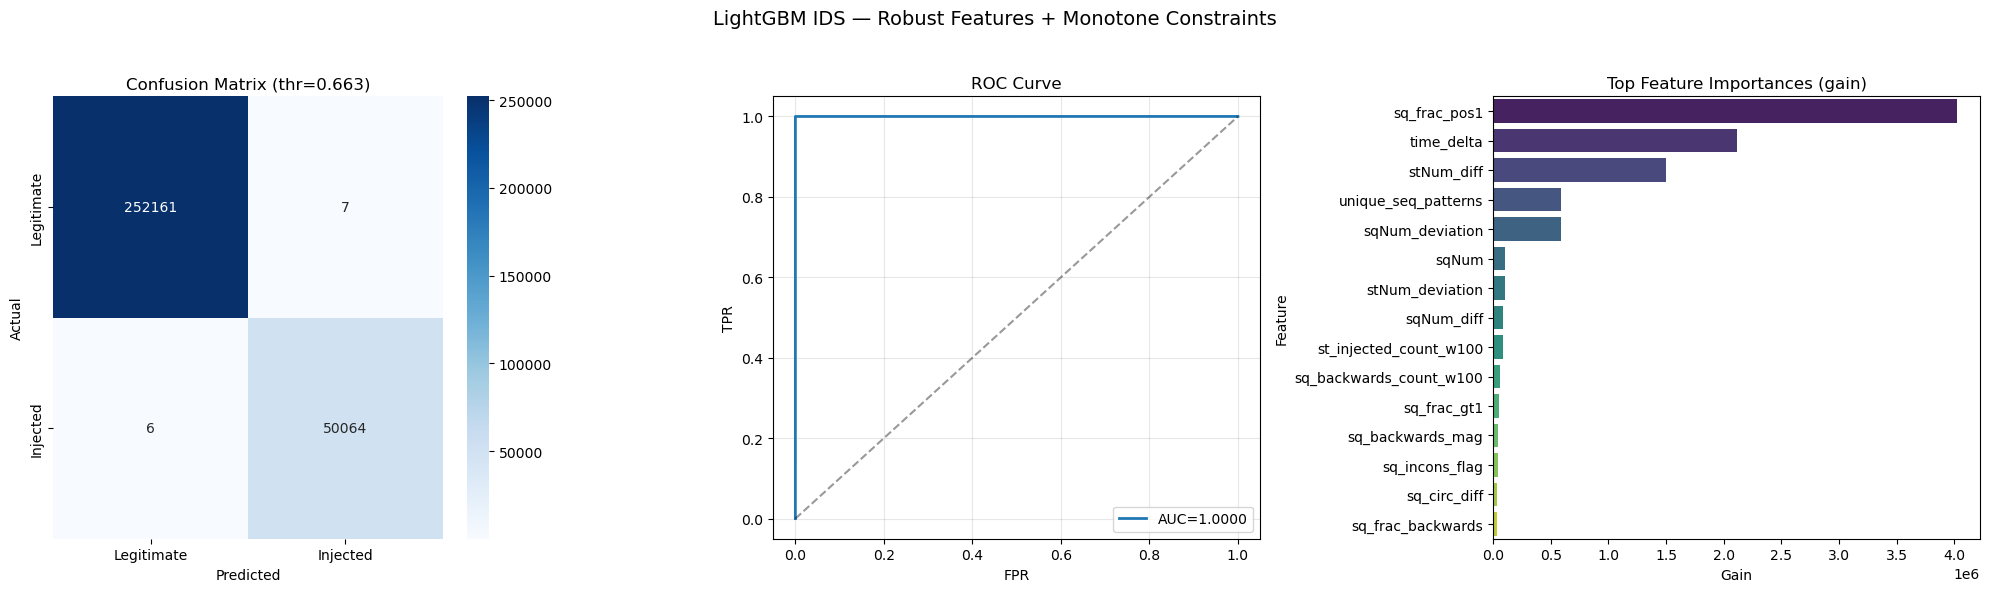


💾 Saving model package...
✓ Saved → ids_lgbm_model.joblib

✅ DONE — Model trained, policy threshold selected, package saved

🔴 Example (injected-side view) — prev→curr

🧩 CORE FIELDS (prev → curr)
• sqNum: 57 → 43 (Δ=-14)
• stNum: 577 → 578 (Δ=1)
• Δt   : 2.600 s
• heartbeat guard: 300–5000 ms | dt_in_baseline=1 | dt_in_pub=0
• flags: sq_backwards=1, sq_jump>1=0, st_change_with_cmd=0, st_change_without_cmd=1

🟢 Example (legitimate-side view) — prev→curr

🧩 CORE FIELDS (prev → curr)
• sqNum: 52 → 53 (Δ=1)
• stNum: 618 → 618 (Δ=0)
• Δt   : 4.900 s
• heartbeat guard: 300–5000 ms | dt_in_baseline=1 | dt_in_pub=0
• flags: sq_backwards=0, sq_jump>1=0, st_change_with_cmd=0, st_change_without_cmd=0


In [7]:
# ============================================================
# 🚀 LightGBM IDS — Robust Features + Monotone Constraints
#     (NO test leakage, imbalance-aware, policy-driven threshold)
#     + prev→curr operator explainer
#     👇 This version locks the 44-feature schema you asked for
# ============================================================

import os, gc, ast, json, time, warnings, hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings("ignore")

print("\n" + "="*60)
print("🚀 LightGBM IDS — Robust Features + Monotone Constraints")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================
CHUNK_SIZE       = 50_000
SAMPLE_RATE      = 1.0
WINDOW           = 10            # short rolling window for base features
LONG_WINDOW      = 100           # long-window features (_w100)
SEQ_MOD          = 256           # circular sequence modulus
DATA_CSV         = "dataset/augmented_data.csv"
NPZ_FILE_BASE    = "preprocessed_idsv2.npz"   # will be replaced by versioned name
RANDOM_STATE     = 42
TEST_SIZE        = 0.30
VAL_SIZE         = 0.20          # of TRAIN
N_ESTIMATORS     = 400

# ---- Threshold policy (pick operating point on VALIDATION) ----
OP_MODE              = "target_recall"   # "f1" | "target_recall" | "max_fpr" | "cost"
TARGET_RECALL        = 0.9998
MAX_FPR_PER_MILLION  = 80
COST_FP              = 1.0
COST_FN              = 5.0

# LightGBM params: fully deterministic for reproducibility
LGBM_PARAMS = dict(
    objective="binary",
    metric="binary_logloss",
    boosting_type="gbdt",
    num_leaves=63,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    num_threads=1,               # deterministic
    deterministic=True,          # deterministic
    feature_fraction_seed=RANDOM_STATE,
    bagging_seed=RANDOM_STATE,
    data_random_seed=RANDOM_STATE,
    device="cpu",
    seed=RANDOM_STATE,
    force_col_wise=True,
)

print("\n📊 Configuration")
print(f"  Chunk size        : {CHUNK_SIZE:,}")
print(f"  Sample rate       : {SAMPLE_RATE}")
print(f"  Window size       : {WINDOW}")
print(f"  Estimators        : {N_ESTIMATORS}")
print(f"  Data file         : {DATA_CSV}")
print(f"  Output NPZ        : {NPZ_FILE_BASE}")
print(f"  Splits            : TEST={TEST_SIZE}, VAL(of train)={VAL_SIZE}")
print(f"  Threshold policy  : {OP_MODE}")

# ===========================
# HELPERS
# ===========================
CMD_ALIASES = ["cmd","command","cmd_bool","cmd_bit","command_bit","bitstring_ones","allData"]
PUB_ALIASES = ["publisher_id","publisher","AppID","app_id","gocbRef","goose_id"]

# The exact 44-feature schema (ORDER LOCKED)
EXPECTED_44 = [
    'time_delta', 'time_delta_zscore', 'sqNum', 'stNum',
    'sqNum_diff', 'stNum_diff', 'sqNum_diff_abs', 'stNum_diff_abs',
    'sq_backwards_flag', 'sq_jump_gt1_flag', 'sq_jump_gt1_abs_flag',
    'sq_backwards_mag', 'sq_jump_mag',
    'st_change_flag', 'st_change_with_cmd_flag', 'st_change_without_cmd_flag',
    'sqNum_rolling_mean', 'sqNum_rolling_std', 'sqNum_rolling_median', 'sqNum_deviation',
    'stNum_rolling_mean', 'stNum_rolling_std', 'stNum_rolling_median', 'stNum_deviation',
    'sq_frac_pos1', 'sq_frac_gt1', 'sq_frac_backwards', 'st_change_rate',
    'sqNum_consistency', 'stNum_consistency', 'unique_seq_patterns', 'unique_state_patterns',
    'sq_circ_diff', 'sq_wrap_flag', 'sq_incons_flag',
    'sq_incons_count_w100', 'sq_backwards_count_w100', 'sq_jump_abs_count_w100',
    'sq_frac_pos1_w100', 'sq_residual_abs_sum_w100', 'sq_circ_diff_std_w100',
    'st_injected_count_w100', 'st_change_count_w100', 'st_change_rate_w100'
]

# Δt guard features (added AFTER split): total +6 to reach 50 train features
DT_GUARDS = [
    "dt_in_baseline_flag", "dt_below_baseline", "dt_above_baseline",
    "dt_in_pub_baseline_flag", "dt_above_pub_baseline", "dt_below_pub_baseline"
]

def detect_columns(csv_path):
    cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
    has_cmd = next((c for c in CMD_ALIASES if c in cols), None)
    has_pub = next((c for c in PUB_ALIASES if c in cols), None)
    for n in ["sqNum","stNum","timestamp","label"]:
        if n not in cols:
            raise ValueError(f"Required column '{n}' not found in CSV.")
    return has_cmd, has_pub

def encode_booleanish(x):
    try:
        if isinstance(x, str):
            xs = x.replace("'", '"').strip()
            if xs.startswith("["):
                v = ast.literal_eval(xs)
                if isinstance(v, list) and v and isinstance(v[0], dict) and "boolean" in v[0]:
                    return 1 if v[0]["boolean"] else 0
            try:
                v = json.loads(xs)
                if isinstance(v, bool): return 1 if v else 0
            except: pass
            xs_low = xs.lower()
            if "true" in xs_low: return 1
            if "false" in xs_low: return 0
    except: pass
    if isinstance(x, (int,float)): return 1 if x!=0 else 0
    return 1 if str(x).strip().lower() in {"1","true","t","yes","y"} else 0

def parse_time_seconds(time_str):
    try:
        s = str(time_str)
        if ":" in s:
            m, sec = s.split(":")
            return int(m)*60.0 + float(sec)
        return float(s)
    except:
        return 0.0

def count_rows_fast(path):
    cnt=0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in f: cnt+=1
    return max(0, cnt-1)

def versioned_npz_name(expected_names, window, long_window, seq_mod):
    payload = {"names": expected_names, "window": window, "long_window": long_window, "seq_mod": seq_mod}
    sig = hashlib.md5(json.dumps(payload, sort_keys=True).encode()).hexdigest()[:8]
    return f"preprocessed_idsv2_win{window}_f{len(expected_names)}_{sig}.npz"

# ===========================
# PREPROCESS (chunked) — LOCKED TO 44 FEATURES
# ===========================
print("\n[1/6] PREPROCESSING (chunked)")
print("-"*40)

cmd_col, pub_col = detect_columns(DATA_CSV)
print(f"Detected columns → cmd: {cmd_col or '—'} | publisher: {pub_col or '—'}")

total_rows = count_rows_fast(DATA_CSV)
use_rows = int(total_rows * SAMPLE_RATE)
print(f"Rows (total)      : {total_rows:,}")
print(f"Rows (used)       : {use_rows:,}")

NPZ_FILE = versioned_npz_name(EXPECTED_44, WINDOW, LONG_WINDOW, SEQ_MOD)

def calc_features(df: pd.DataFrame, window=WINDOW, wlong=LONG_WINDOW, seq_mod=SEQ_MOD):
    out = df.copy()
    if cmd_col and cmd_col in out.columns and "cmd" not in out.columns:
        out = out.rename(columns={cmd_col:"cmd"})
    if pub_col and pub_col in out.columns and "publisher_id" not in out.columns:
        out = out.rename(columns={pub_col:"publisher_id"})

    # Core numeric conversions
    for c in ["sqNum","stNum"]:
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0).astype(int)

    out["t_sec"] = out["timestamp"].apply(parse_time_seconds)
    out["time_delta"] = out["t_sec"].diff().fillna(0).clip(lower=0)

    # diffs
    out["sqNum_diff"] = out["sqNum"].diff().fillna(0)
    out["stNum_diff"] = out["stNum"].diff().fillna(0)
    out["sqNum_diff_abs"] = out["sqNum_diff"].abs()
    out["stNum_diff_abs"] = out["stNum_diff"].abs()

    out["sq_backwards_flag"] = (out["sqNum_diff"] < 0).astype(int)
    out["sq_jump_gt1_flag"]  = (out["sqNum_diff"] > 1).astype(int)
    out["sq_jump_gt1_abs_flag"] = (out["sqNum_diff_abs"] > 1).astype(int)
    out["sq_backwards_mag"]  = (-out["sqNum_diff"]).clip(lower=0)
    out["sq_jump_mag"]       = out["sqNum_diff_abs"]

    out["st_change_flag"]    = (out["stNum_diff"] != 0).astype(int)

    if "cmd" in out.columns:
        out["cmd"] = out["cmd"].apply(encode_booleanish)
        out["st_change_with_cmd_flag"]    = ((out["st_change_flag"]==1)&(out["cmd"]==1)).astype(int)
        out["st_change_without_cmd_flag"] = ((out["st_change_flag"]==1)&(out["cmd"]==0)).astype(int)
    else:
        out["st_change_with_cmd_flag"]    = 0
        out["st_change_without_cmd_flag"] = out["st_change_flag"]

    # rolling stats
    for col in ["sqNum","stNum"]:
        out[f"{col}_rolling_mean"]   = out[col].rolling(window=window, min_periods=1).mean()
        out[f"{col}_rolling_std"]    = out[col].rolling(window=window, min_periods=1).std().fillna(0)
        out[f"{col}_rolling_median"] = out[col].rolling(window=window, min_periods=1).median()
        out[f"{col}_deviation"]      = (out[col]-out[f"{col}_rolling_median"]).abs()

    out["sq_frac_pos1"]       = (out["sqNum_diff_abs"]==1).astype(float).rolling(window=window, min_periods=1).mean()
    out["sq_frac_gt1"]        = (out["sqNum_diff_abs"]>1).astype(float).rolling(window=window, min_periods=1).mean()
    out["sq_frac_backwards"]  = (out["sqNum_diff"]<0).astype(float).rolling(window=window, min_periods=1).mean()
    out["st_change_rate"]     = out["st_change_flag"].astype(float).rolling(window=window, min_periods=1).mean()

    out["sqNum_consistency"]  = out["sq_frac_pos1"]
    out["stNum_consistency"]  = (out["stNum_diff"]==1).astype(float).rolling(window=window, min_periods=1).mean()

    out["unique_seq_patterns"]   = out["sqNum_diff_abs"].rolling(window=window, min_periods=1).std().fillna(0)
    out["unique_state_patterns"] = out["stNum_diff_abs"].rolling(window=window, min_periods=1).std().fillna(0)

    # time zscore
    td = out["time_delta"].values
    out["time_delta_zscore"] = (np.abs(stats.zscore(td)) if np.std(td)>0 else np.zeros_like(td))

    # circular diff + wrap/inconsistency flags
    out["sq_circ_diff"] = (out["sqNum"].diff().fillna(0) % seq_mod).astype(int)
    out["sq_wrap_flag"] = (out["sq_circ_diff"] < out["sqNum_diff_abs"]).astype(int)
    out["sq_incons_flag"] = ((out["sqNum_diff_abs"] != 1) | (out["stNum_diff_abs"] > 1)).astype(int)

    # long-window counts/stats (w=100)
    out["sq_incons_count_w100"]    = out["sq_incons_flag"].rolling(window=wlong, min_periods=1).sum()
    out["sq_backwards_count_w100"] = (out["sqNum_diff"] < 0).astype(int).rolling(window=wlong, min_periods=1).sum()
    out["sq_jump_abs_count_w100"]  = (out["sqNum_diff_abs"] > 1).astype(int).rolling(window=wlong, min_periods=1).sum()
    out["sq_frac_pos1_w100"]       = (out["sqNum_diff_abs"]==1).astype(float).rolling(window=wlong, min_periods=1).mean()
    out["sq_residual_abs_sum_w100"]= out["sqNum_deviation"].abs().rolling(window=wlong, min_periods=1).sum()
    out["sq_circ_diff_std_w100"]   = out["sq_circ_diff"].rolling(window=wlong, min_periods=1).std().fillna(0)
    out["st_change_count_w100"]    = out["st_change_flag"].rolling(window=wlong, min_periods=1).sum()
    out["st_change_rate_w100"]     = out["st_change_flag"].astype(float).rolling(window=wlong, min_periods=1).mean()
    if "cmd" in out.columns:
        out["st_injected_count_w100"] = ((out["st_change_flag"]==1)&(out["cmd"]==0)).astype(int).rolling(window=wlong, min_periods=1).sum()
    else:
        out["st_injected_count_w100"] = 0

    if "publisher_id" not in out.columns:
        out["publisher_id"] = "unknown"
    else:
        out["publisher_id"] = out["publisher_id"].astype(str)

    # Keep ONLY the 44 expected (and in the exact order)
    for name in EXPECTED_44:
        if name not in out.columns:
            out[name] = 0
    out = out[EXPECTED_44].copy()

    # numeric safety
    out[EXPECTED_44] = out[EXPECTED_44].replace([np.inf,-np.inf], np.nan).fillna(0)

    return out

def build_or_load_npz():
    # If exists, validate schema; otherwise build
    if os.path.exists(NPZ_FILE):
        print(f"🔁 Using cached preprocessed file: {NPZ_FILE_BASE}")
        npz = np.load(NPZ_FILE, allow_pickle=True)
        feat_names = list(npz["feature_names"])
        if feat_names != EXPECTED_44:
            print("⚠️  Cached schema mismatch; rebuilding with locked 44-feature schema...")
            os.remove(NPZ_FILE)
        else:
            return npz

    # Build
    base_cols = ["sqNum","stNum","timestamp","label"]
    read_cols = base_cols + ([cmd_col] if cmd_col else []) + ([pub_col] if pub_col else [])
    skiprows = (sorted(np.random.choice(range(1,total_rows+1), size=int(total_rows*(1-SAMPLE_RATE)), replace=False))
                if SAMPLE_RATE<1.0 else None)

    feat_blocks, label_blocks, pub_blocks, last_tail = [], [], [], None
    chunk_iter = pd.read_csv(DATA_CSV, chunksize=CHUNK_SIZE, usecols=read_cols, skiprows=skiprows)
    total_chunks = (use_rows // CHUNK_SIZE) + 1

    for chunk in tqdm(chunk_iter, total=total_chunks, desc="Chunks"):
        if last_tail is not None:
            chunk = pd.concat([last_tail, chunk], ignore_index=True)
        f = calc_features(chunk, window=WINDOW, wlong=LONG_WINDOW, seq_mod=SEQ_MOD)
        if last_tail is not None:
            f = f.iloc[len(last_tail):].reset_index(drop=True)

        feat_blocks.append(f.values)
        label_blocks.append(chunk["label"].values[-len(f):])
        pub_blocks.append((chunk[pub_col].astype(str).values[-len(f):] if pub_col and (pub_col in chunk.columns)
                           else np.array(["unknown"]*len(f))))
        last_tail = chunk.tail(WINDOW).copy()
        gc.collect()

    X_base = np.vstack(feat_blocks)
    y_all  = np.concatenate(label_blocks).astype(int)
    pubs   = np.concatenate(pub_blocks).astype(str)

    print(f"💾 Saving preprocessed arrays → {NPZ_FILE_BASE}")
    np.savez_compressed(NPZ_FILE,
                        features=X_base,
                        feature_names=np.array(EXPECTED_44, dtype=object),
                        labels=y_all,
                        publisher_id=pubs)
    return np.load(NPZ_FILE, allow_pickle=True)

# Build or load
npz = build_or_load_npz()

# ===========================
# LOAD PREPROCESSED
# ===========================
print("\n[2/6] LOAD PREPROCESSED")
print("-"*40)

X_base = np.array(npz["features"])
feat_names = list(npz["feature_names"])
y_all = np.array(npz["labels"]).astype(int)
pubs = np.array(npz["publisher_id"]).astype(str) if "publisher_id" in npz else np.array(["unknown"]*len(y_all))
print(f"✓ Features: {X_base.shape}, Labels: {y_all.shape}, Publishers: {len(pubs)}")

# ===========================
# SPLIT + LEARN TIMING GUARDS (TRAIN normals only)
# ===========================
print("\n[3/6] SPLIT + LEARN TIMING GUARDS (from TRAIN normals only)")
print("-"*40)

X_train_base, X_test_base, y_train_all, y_test, pubs_train_all, pubs_test = train_test_split(
    X_base, y_all, pubs, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
)
X_tr_base, X_val_base, y_tr, y_val, pubs_tr, pubs_val = train_test_split(
    X_train_base, y_train_all, pubs_train_all, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_train_all
)

Xtr = pd.DataFrame(X_tr_base,  columns=feat_names)
Xva = pd.DataFrame(X_val_base, columns=feat_names)
Xte = pd.DataFrame(X_test_base, columns=feat_names)

# Global Δt guard from TRAIN NORMALS
dt_ms_tr = Xtr.loc[y_tr==0, "time_delta"].values * 1000.0
q_lo = float(np.nanquantile(dt_ms_tr, 0.05)) if len(dt_ms_tr) else 1.0
q_hi = float(np.nanquantile(dt_ms_tr, 0.95)) if len(dt_ms_tr) else (q_lo + 1.0)
q_lo = max(0.1, q_lo); q_hi = max(q_lo + 0.1, q_hi)

def add_global_dt_guards(df):
    dt_ms = df["time_delta"].values * 1000.0
    df["dt_in_baseline_flag"]  = ((dt_ms >= q_lo) & (dt_ms <= q_hi)).astype(int)
    df["dt_below_baseline"]    = (dt_ms < q_lo).astype(int)
    df["dt_above_baseline"]    = (dt_ms > q_hi).astype(int)
    return df

Xtr = add_global_dt_guards(Xtr)
Xva = add_global_dt_guards(Xva)
Xte = add_global_dt_guards(Xte)

# Optional per-publisher guards
def add_per_pub(df_in, pubs_vec, ref_df, ref_pubs, ref_y):
    df = df_in.copy()
    dt_ms_ref = ref_df["time_delta"].values * 1000.0
    bounds = {}
    for p in np.unique(ref_pubs):
        m = (ref_pubs==p) & (ref_y==0)
        if m.sum() >= 50:
            vals = dt_ms_ref[m]
            lo = float(np.nanquantile(vals, 0.05))
            hi = float(np.nanquantile(vals, 0.95))
            if hi <= lo: hi = lo + 0.1
            bounds[p] = (lo, hi)
    dt_ms = df["time_delta"].values * 1000.0
    lo_vec = np.full(len(df), q_lo); hi_vec = np.full(len(df), q_hi)
    for i,p in enumerate(pubs_vec):
        if p in bounds: lo_vec[i], hi_vec[i] = bounds[p]
    df["dt_in_pub_baseline_flag"] = ((dt_ms >= lo_vec) & (dt_ms <= hi_vec)).astype(int)
    df["dt_above_pub_baseline"]   = (dt_ms > hi_vec).astype(int)
    df["dt_below_pub_baseline"]   = (dt_ms < lo_vec).astype(int)
    return df

if len(np.unique(pubs_tr)) > 1:
    Xtr = add_per_pub(Xtr, pubs_tr, Xtr, pubs_tr, y_tr)
    Xva = add_per_pub(Xva, pubs_val, Xtr, pubs_tr, y_tr)
    Xte = add_per_pub(Xte, pubs_test, Xtr, pubs_tr, y_tr)
else:
    for df in (Xtr, Xva, Xte):
        df["dt_in_pub_baseline_flag"] = 0
        df["dt_above_pub_baseline"]   = 0
        df["dt_below_pub_baseline"]   = 0

final_feat_names = list(Xtr.columns)  # 44 + 6 = 50
X_train = Xtr.values
X_val   = Xva.values
X_test  = Xte.values

print(f"✓ Train={X_train.shape} | Val={X_val.shape} | Test={X_test.shape}")
print(f"✓ Global Δt guard ms range (TRAIN normals): [{q_lo:.1f}, {q_hi:.1f}]")

# ===========================
# TRAIN (monotone) + imbalance-aware
# ===========================
print("\n[4/6] TRAIN LIGHTGBM (monotone constraints, imbalance-aware)")
print("-"*40)

# Only constrain the "core" + guard features (extras default to 0 to match your target log)
mono_map = {
    # Good → risk down
    "sq_frac_pos1": -1, "sqNum_consistency": -1, "stNum_consistency": -1,
    "dt_in_baseline_flag": -1, "dt_in_pub_baseline_flag": -1,
    # Bad → risk up
    "sq_backwards_flag": +1, "sq_jump_gt1_flag": +1, "sq_jump_mag": +1,
    "st_change_flag": +1, "st_change_without_cmd_flag": +1,
    "dt_above_baseline": +1, "dt_below_baseline": +1,
    "dt_above_pub_baseline": +1, "dt_below_pub_baseline": +1,
    # Helpful when command exists
    "st_change_with_cmd_flag": -1,
}
monotone_constraints = [mono_map.get(fn, 0) for fn in final_feat_names]
LGBM_PARAMS["monotone_constraints"] = monotone_constraints

pos = max(1, int((y_tr==1).sum())); neg = max(1, int((y_tr==0).sum()))
LGBM_PARAMS["scale_pos_weight"] = neg/pos

print("Monotone constraints summary (name → sign):")
for n,m in zip(final_feat_names, monotone_constraints):
    if m != 0:
        print(f"  {n:28s} -> {m:+d}")
print(f"\nClass weights: scale_pos_weight = {neg}/{pos} = {neg/pos:.3f}")

train_set = lgb.Dataset(X_train, label=y_tr, feature_name=final_feat_names, free_raw_data=False)
valid_set = lgb.Dataset(X_val,   label=y_val, feature_name=final_feat_names, reference=train_set, free_raw_data=False)

start = time.time()
model = lgb.train(
    LGBM_PARAMS,
    train_set,
    num_boost_round=N_ESTIMATORS,
    valid_sets=[valid_set],              # validate on VAL (no test leakage)
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(100)]
)
print(f"✓ Training complete in {time.time()-start:.1f}s | Best iter: {model.best_iteration}")

# ===========================
# THRESHOLD SELECTION (policy-driven) + TEST EVAL
# ===========================
print("\n[5/6] THRESHOLD SELECTION (policy-driven) + EVALUATION (TEST)")
print("-"*40)

def eval_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    acc  = (tp + tn) / max(1, (tn+fp+fn+tp))
    prec = tp / max(1, (tp+fp))
    rec  = tp / max(1, (tp+fn))
    f1   = 0.0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    fpr  = fp / max(1, (fp+tn))
    return dict(thr=thr, tn=tn, fp=fp, fn=fn, tp=tp, acc=acc, prec=prec, rec=rec, f1=f1, fpr=fpr)

def scan_thresholds(y_true, proba, grid=None):
    if grid is None:
        grid = np.unique(np.concatenate([
            np.linspace(0.00, 0.50, 501),
            np.linspace(0.50, 0.99, 100),
            np.array([0.995, 0.9975, 0.999, 0.9995, 1.0])
        ]))
    rows = [eval_at_threshold(y_true, proba, t) for t in grid]
    return pd.DataFrame(rows)

def find_best_threshold_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    thr = np.append(thr, 1.0)
    f1s = (2*prec*rec)/np.clip(prec+rec, 1e-9, None)
    idx = int(np.nanargmax(f1s))
    return float(thr[idx])

# predictions
proba_val  = model.predict(X_val,  num_iteration=model.best_iteration)
proba_test = model.predict(X_test, num_iteration=model.best_iteration)

# policy selection on VALIDATION ONLY
dfv  = scan_thresholds(y_val, proba_val)
thr_f1 = find_best_threshold_f1(y_val, proba_val)

if OP_MODE == "f1":
    chosen_thr = thr_f1

elif OP_MODE == "target_recall":
    cand = dfv[dfv["rec"] >= TARGET_RECALL].copy()
    if len(cand):
        cand.sort_values(["fp","thr"], ascending=[True, False], inplace=True)
        chosen_thr = float(cand.iloc[0]["thr"])
    else:
        chosen_thr = thr_f1

elif OP_MODE == "max_fpr":
    negs = int((y_val == 0).sum())
    max_fp = MAX_FPR_PER_MILLION * max(1, negs) / 1_000_000.0
    cand = dfv[dfv["fp"] <= max_fp].copy()
    if len(cand):
        cand.sort_values(["rec","thr"], ascending=[False, False], inplace=True)
        chosen_thr = float(cand.iloc[0]["thr"])
    else:
        chosen_thr = thr_f1

elif OP_MODE == "cost":
    cost = COST_FN*dfv["fn"] + COST_FP*dfv["fp"]
    chosen_thr = float(dfv.loc[cost.idxmin(), "thr"])
else:
    raise ValueError(f"Unknown OP_MODE: {OP_MODE}")

def prn(tag, res):
    print(f"{tag:<10} thr={res['thr']:.4f}  Acc={res['acc']:.4f}  Prec={res['prec']:.4f}  Rec={res['rec']:.4f}  F1={res['f1']:.4f}  FPR={res['fpr']:.6f}  CM=[[{res['tn']},{res['fp']}],[{res['fn']},{res['tp']}] ]")

res_050 = eval_at_threshold(y_test, proba_test, 0.50)
res_f1  = eval_at_threshold(y_test, proba_test, thr_f1)
res_ch  = eval_at_threshold(y_test, proba_test, chosen_thr)

print(f"\nPolicy: {OP_MODE}  →  chosen_thr (from VAL) = {chosen_thr:.4f}")
prn("Test@0.50", res_050)
prn("Test@F1  ", res_f1)
prn("Test@OP  ", res_ch)

# For downstream visuals/reporting use chosen OP
tuned_thr = chosen_thr
cm = np.array([[res_ch['tn'], res_ch['fp']], [res_ch['fn'], res_ch['tp']]])

# Also compute ROC/PR on TEST (policy-agnostic)
fpr, tpr, _ = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr)
pr_auc  = average_precision_score(y_test, proba_test)

# ===========================
# VISUALIZATION
# ===========================
print("\n[6/6] VISUALIZATIONS")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=["Legitimate", "Injected"], yticklabels=["Legitimate", "Injected"])
axes[0].set_title(f'Confusion Matrix (thr={tuned_thr:.3f})'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

axes[1].plot(fpr, tpr, label=f'AUC={roc_auc:.4f}', linewidth=2)
axes[1].plot([0,1],[0,1],'k--',alpha=0.4)
axes[1].set_title('ROC Curve'); axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR'); axes[1].legend(); axes[1].grid(alpha=0.3)

imp_gain = model.feature_importance(importance_type='gain')
imp_df = pd.DataFrame({'feature': final_feat_names, 'gain': imp_gain}).sort_values('gain', ascending=False)
sns.barplot(data=imp_df.head(15), x='gain', y='feature', ax=axes[2], palette='viridis')
axes[2].set_title('Top Feature Importances (gain)'); axes[2].set_xlabel('Gain'); axes[2].set_ylabel('Feature')

plt.suptitle('LightGBM IDS — Robust Features + Monotone Constraints', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('ids_lgbm_results.png', dpi=150)
plt.show()

# ===========================
# SAVE MODEL PACKAGE
# ===========================
print("\n💾 Saving model package...")
pkg = {
    "lgbm_model": model,
    "feature_names": final_feat_names,
    "q_lo_ms": q_lo,
    "q_hi_ms": q_hi,
    "monotone_constraints": LGBM_PARAMS["monotone_constraints"],
    "scale_pos_weight": LGBM_PARAMS["scale_pos_weight"],
    "tuned_threshold": float(tuned_thr),
    "op_mode": OP_MODE,
    "op_params": {
        "target_recall": TARGET_RECALL,
        "max_fpr_per_million": MAX_FPR_PER_MILLION,
        "cost_fp": COST_FP,
        "cost_fn": COST_FN
    },
    "roc_auc_test": float(roc_auc),
    "pr_auc_test": float(pr_auc),
}
joblib.dump(pkg, "ids_lgbm_model.joblib")
print("✓ Saved → ids_lgbm_model.joblib")

print("\n" + "="*60)
print("✅ DONE — Model trained, policy threshold selected, package saved")
print("="*60)

# ===========================
# 🔎 Tiny operator explainer (prev → curr, robust demo)
# ===========================
def explain_row_prev_curr(xrow, feat_names=final_feat_names, q_lo_ms=q_lo, q_hi_ms=q_hi):
    f = dict(zip(feat_names, xrow))
    sq, st = f.get("sqNum", np.nan), f.get("stNum", np.nan)
    d_sq, d_st = f.get("sqNum_diff", np.nan), f.get("stNum_diff", np.nan)
    sq_prev = sq - d_sq if np.isfinite(sq) and np.isfinite(d_sq) else np.nan
    st_prev = st - d_st if np.isfinite(st) and np.isfinite(d_st) else np.nan
    dt = f.get("time_delta", np.nan)
    flags = {
        "sq_backwards": int(f.get("sq_backwards_flag", 0)),
        "sq_jump>1": int(f.get("sq_jump_gt1_flag", 0)),
        "st_change_with_cmd": int(f.get("st_change_with_cmd_flag", 0)),
        "st_change_without_cmd": int(f.get("st_change_without_cmd_flag", 0)),
        "dt_in_baseline": int(f.get("dt_in_baseline_flag", 0)),
        "dt_in_pub": int(f.get("dt_in_pub_baseline_flag", 0)),
    }
    print("\n🧩 CORE FIELDS (prev → curr)")
    print(f"• sqNum: {int(sq_prev) if np.isfinite(sq_prev) else 'N/A'} → {int(sq) if np.isfinite(sq) else 'N/A'} (Δ={int(d_sq) if np.isfinite(d_sq) else 'N/A'})")
    print(f"• stNum: {int(st_prev) if np.isfinite(st_prev) else 'N/A'} → {int(st) if np.isfinite(st) else 'N/A'} (Δ={int(d_st) if np.isfinite(d_st) else 'N/A'})")
    if "time_delta" in feat_names:
        print(f"• Δt   : {dt:.3f} s")
    print(f"• heartbeat guard: {q_lo_ms:.0f}–{q_hi_ms:.0f} ms | dt_in_baseline={flags['dt_in_baseline']} | dt_in_pub={(flags['dt_in_pub'] if flags['dt_in_pub'] in [0,1] else 'N/A')}")
    print(f"• flags: sq_backwards={flags['sq_backwards']}, sq_jump>1={flags['sq_jump>1']}, "
          f"st_change_with_cmd={flags['st_change_with_cmd']}, st_change_without_cmd={flags['st_change_without_cmd']}")

# Demo rows at the chosen threshold
try:
    proba_test_demo = model.predict(X_test, num_iteration=model.best_iteration)
    pos_idx = np.where(proba_test_demo >= tuned_thr)[0]
    neg_idx = np.where(proba_test_demo <  tuned_thr)[0]

    if len(pos_idx) == 0:
        pos_idx = np.array([int(np.argmax(proba_test_demo))])
        print("\n(Info) No positives at chosen threshold; showing max-prob sample instead.")
    if len(neg_idx) == 0:
        neg_idx = np.array([int(np.argmin(proba_test_demo))])
        print("(Info) No negatives at chosen threshold; showing min-prob sample instead.")

    print("\n🔴 Example (injected-side view) — prev→curr")
    explain_row_prev_curr(X_test[int(pos_idx[0])])

    print("\n🟢 Example (legitimate-side view) — prev→curr")
    explain_row_prev_curr(X_test[int(neg_idx[0])])
except Exception as e:
    print(f"(Demo skipped: {e})")


In [9]:
npz = np.load("preprocessed_idsv2.npz", allow_pickle=True)
print(len(npz["feature_names"]), list(npz["feature_names"]))

30 ['time_delta', 'time_delta_zscore', 'sqNum', 'stNum', 'sqNum_diff', 'stNum_diff', 'sqNum_diff_abs', 'stNum_diff_abs', 'sq_backwards_flag', 'sq_jump_gt1_flag', 'sq_jump_mag', 'st_change_flag', 'st_change_with_cmd_flag', 'st_change_without_cmd_flag', 'sqNum_rolling_mean', 'sqNum_rolling_std', 'sqNum_rolling_median', 'sqNum_deviation', 'stNum_rolling_mean', 'stNum_rolling_std', 'stNum_rolling_median', 'stNum_deviation', 'sq_frac_pos1', 'sq_frac_gt1', 'sq_frac_backwards', 'st_change_rate', 'sqNum_consistency', 'stNum_consistency', 'unique_seq_patterns', 'unique_state_patterns']



🚀 LightGBM IDS — Clean Decisions + Operator XAI (Event Windows)

📊 Configuration
  Data file         : dataset/augmented_data.csv
  Output NPZ        : preprocessed_with_rows_win10_f44_c0e2e975.npz
  Splits            : TEST=0.3, VAL(of train)=0.2
  Threshold policy  : target_recall
  Operator view     : pre=10, post=20, dir=operator_reports

[1/6] PREPROCESSING (chunked)
----------------------------------------
Detected columns → cmd: allData | publisher: —
Rows (total)      : 1,007,460
Rows (used)       : 1,007,460
Chunks: 

21it [00:23,  1.10s/it]


💾 Saving preprocessed arrays → artifacts/preprocessed_with_rows_win10_f44_c0e2e975.npz

[2/6] LOAD PREPROCESSED
----------------------------------------
✓ Features: (1007460, 44), Labels: (1007460,), Publishers: 1007460

[3/6] SPLIT + LEARN TIMING GUARDS (from TRAIN normals only)
----------------------------------------
✓ Train=(564177, 50) | Val=(141045, 50) | Test=(302238, 50)
✓ Global Δt guard ms range (TRAIN normals): [300.0, 5000.0]

[4/6] TRAIN LIGHTGBM (monotone constraints, imbalance-aware)
----------------------------------------
Monotone constraints summary (name → sign):
  sq_backwards_flag            -> +1
  sq_jump_gt1_flag             -> +1
  sq_jump_mag                  -> +1
  st_change_flag               -> +1
  st_change_with_cmd_flag      -> -1
  st_change_without_cmd_flag   -> +1
  sq_frac_pos1                 -> -1
  sqNum_consistency            -> -1
  stNum_consistency            -> -1
  dt_in_baseline_flag          -> -1
  dt_below_baseline            -> +1
  dt

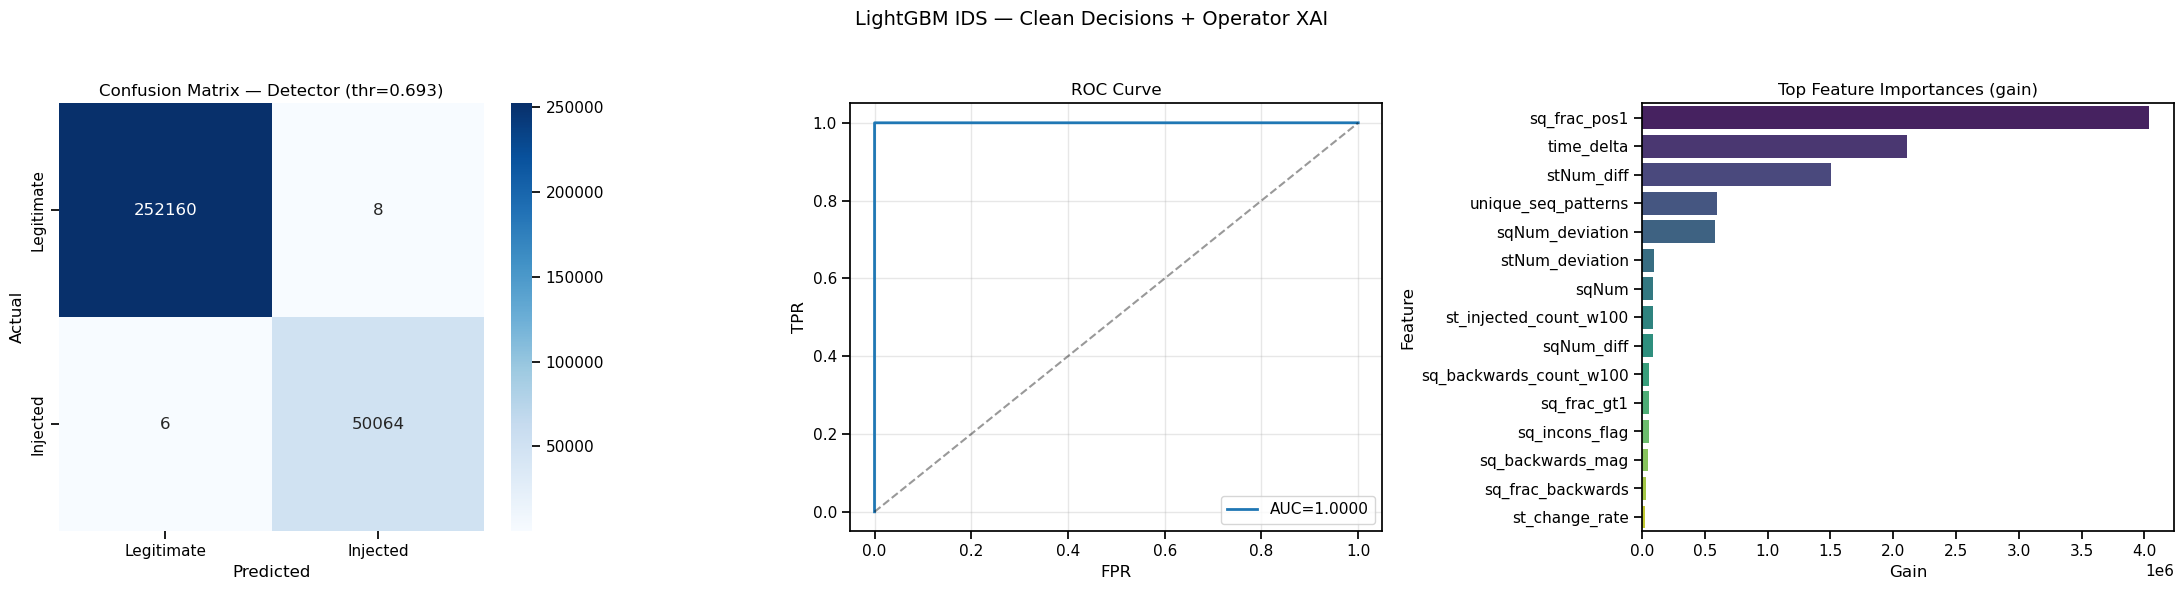


💾 Saving model package...
✓ Saved → artifacts/ids_lgbm_model.joblib

✅ DONE — Detector is pure; Operator XAI windows written to operator_reports/


In [3]:
# ============================================================
# 🚀 LightGBM IDS — Clean Decisions + Operator XAI (Event Windows)
#     • NO label changes after the model (no latching)
#     • Features computed in ORIGINAL CSV ORDER (no sorting)
#     • Operator reports show 10 BEFORE and 20 AFTER each event
#     • Reports include both csv_row (original line) and pre_idx
#     • Locked to 44 base features (+6 guard flags after split = 50 train feats)
# ============================================================

import os, gc, ast, json, time, warnings, hashlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings("ignore")
sns.set_context("notebook")

print("\n" + "="*78)
print("🚀 LightGBM IDS — Clean Decisions + Operator XAI (Event Windows)")
print("="*78)

# ===========================
# CONFIGURATION
# ===========================
CHUNK_SIZE       = 50_000
SAMPLE_RATE      = 1.0
WINDOW           = 10           # short rolling/window size
LONG_WINDOW      = 100          # long-window stats (_w100)
SEQ_MOD          = 256          # circular diff modulus
DATA_CSV         = "dataset/augmented_data.csv"

# All artifacts (NPZ, plots, etc.) live here to avoid path glitches
ARTIFACT_DIR     = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

RANDOM_STATE     = 42
TEST_SIZE        = 0.30
VAL_SIZE         = 0.20         # of TRAIN
N_ESTIMATORS     = 400

# ---- Threshold policy ----
OP_MODE              = "target_recall"     # "f1" | "target_recall" | "max_fpr" | "cost"
TARGET_RECALL        = 0.9998
MAX_FPR_PER_MILLION  = 80
COST_FP              = 1.0
COST_FN              = 5.0

# ---- Operator report params ----
OP_DIR               = "operator_reports"
OP_PRE_BEFORE        = 10
OP_POST_AFTER        = 20
OP_MAX_EVENTS        = 40
OP_REQUIRE_POSITIVE  = True
SQ_RESET_MAX         = 1

LGBM_PARAMS = dict(
    objective="binary",
    metric="binary_logloss",
    boosting_type="gbdt",
    num_leaves=63,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    # Determinism (set to 1 thread for strict reproducibility)
    deterministic=True,
    feature_fraction_seed=RANDOM_STATE,
    bagging_seed=RANDOM_STATE,
    data_random_seed=RANDOM_STATE,
    num_threads=1,
    device="cpu",
    seed=RANDOM_STATE,
    force_col_wise=True,
)

def _print_cfg(npz_path_print):
    print("\n📊 Configuration")
    print(f"  Data file         : {DATA_CSV}")
    print(f"  Output NPZ        : {npz_path_print}")
    print(f"  Splits            : TEST={TEST_SIZE}, VAL(of train)={VAL_SIZE}")
    print(f"  Threshold policy  : {OP_MODE}")
    print(f"  Operator view     : pre={OP_PRE_BEFORE}, post={OP_POST_AFTER}, dir={OP_DIR}")

# ===========================
# HELPERS & LOCKED SCHEMA (44)
# ===========================
CMD_ALIASES = ["cmd","command","cmd_bool","cmd_bit","command_bit","bitstring_ones","allData"]
PUB_ALIASES = ["publisher_id","publisher","AppID","app_id","gocbRef","goose_id"]

EXPECTED_44 = [
    'time_delta', 'time_delta_zscore', 'sqNum', 'stNum',
    'sqNum_diff', 'stNum_diff', 'sqNum_diff_abs', 'stNum_diff_abs',
    'sq_backwards_flag', 'sq_jump_gt1_flag', 'sq_jump_gt1_abs_flag',
    'sq_backwards_mag', 'sq_jump_mag',
    'st_change_flag', 'st_change_with_cmd_flag', 'st_change_without_cmd_flag',
    'sqNum_rolling_mean', 'sqNum_rolling_std', 'sqNum_rolling_median', 'sqNum_deviation',
    'stNum_rolling_mean', 'stNum_rolling_std', 'stNum_rolling_median', 'stNum_deviation',
    'sq_frac_pos1', 'sq_frac_gt1', 'sq_frac_backwards', 'st_change_rate',
    'sqNum_consistency', 'stNum_consistency', 'unique_seq_patterns', 'unique_state_patterns',
    'sq_circ_diff', 'sq_wrap_flag', 'sq_incons_flag',
    'sq_incons_count_w100', 'sq_backwards_count_w100', 'sq_jump_abs_count_w100',
    'sq_frac_pos1_w100', 'sq_residual_abs_sum_w100', 'sq_circ_diff_std_w100',
    'st_injected_count_w100', 'st_change_count_w100', 'st_change_rate_w100'
]

DT_GUARDS = [
    "dt_in_baseline_flag", "dt_below_baseline", "dt_above_baseline",
    "dt_in_pub_baseline_flag", "dt_above_pub_baseline", "dt_below_pub_baseline"
]

def versioned_npz_name(expected_names, window, long_window, seq_mod):
    payload = {"names": expected_names, "window": window, "long_window": long_window, "seq_mod": seq_mod}
    sig = hashlib.md5(json.dumps(payload, sort_keys=True).encode()).hexdigest()[:8]
    return os.path.join(ARTIFACT_DIR, f"preprocessed_with_rows_win{window}_f{len(expected_names)}_{sig}.npz")

NPZ_FILE = versioned_npz_name(EXPECTED_44, WINDOW, LONG_WINDOW, SEQ_MOD)
_print_cfg(os.path.basename(NPZ_FILE))

def detect_columns(csv_path):
    cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
    has_cmd = next((c for c in CMD_ALIASES if c in cols), None)
    has_pub = next((c for c in PUB_ALIASES if c in cols), None)
    for n in ["sqNum","stNum","timestamp","label"]:
        if n not in cols:
            raise ValueError(f"Required column '{n}' not found in CSV.")
    return has_cmd, has_pub

def encode_booleanish(x):
    try:
        if isinstance(x, str):
            xs = x.replace("'", '"').strip()
            if xs.startswith("["):
                v = ast.literal_eval(xs)
                if isinstance(v, list) and v and isinstance(v[0], dict) and "boolean" in v[0]:
                    return 1 if v[0]["boolean"] else 0
            try:
                v = json.loads(xs)
                if isinstance(v, bool): return 1 if v else 0
            except: pass
            xs_low = xs.lower()
            if "true" in xs_low: return 1
            if "false" in xs_low: return 0
    except: pass
    if isinstance(x, (int,float)): return 1 if x!=0 else 0
    return 1 if str(x).strip().lower() in {"1","true","t","yes","y"} else 0

def parse_time_seconds(time_str):
    try:
        s = str(time_str)
        if ":" in s:
            m, sec = s.split(":")
            return int(m)*60.0 + float(sec)
        return float(s)
    except:
        return 0.0

def count_rows_fast(path):
    cnt=0
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for _ in f: cnt+=1
    return max(0, cnt-1)

# ===========================
# PREPROCESS (chunked) — KEEP ORIGINAL CSV ORDER + 44 features
# ===========================
print("\n[1/6] PREPROCESSING (chunked)")
print("-"*40)

cmd_col, pub_col = detect_columns(DATA_CSV)
print(f"Detected columns → cmd: {cmd_col or '—'} | publisher: {pub_col or '—'}")

total_rows = count_rows_fast(DATA_CSV)
use_rows = int(total_rows * SAMPLE_RATE)
print(f"Rows (total)      : {total_rows:,}")
print(f"Rows (used)       : {use_rows:,}")

def calc_features_original_order(df: pd.DataFrame, window=WINDOW, wlong=LONG_WINDOW, seq_mod=SEQ_MOD):
    """
    Compute 44 locked features in the ORIGINAL row order (no sorting),
    with per-publisher rolling statistics.
    """
    out = df.copy()
    if cmd_col and cmd_col in out.columns and "cmd" not in out.columns:
        out = out.rename(columns={cmd_col:"cmd"})
    if pub_col and pub_col in out.columns and "publisher_id" not in out.columns:
        out = out.rename(columns={pub_col:"publisher_id"})

    # Ensure publisher id exists
    if "publisher_id" not in out.columns:
        out["publisher_id"] = "__global__"
    else:
        out["publisher_id"] = out["publisher_id"].astype(str)

    for c in ["sqNum","stNum"]:
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0).astype(int)

    out["timestamp_str"] = out["timestamp"].astype(str)
    out["t_sec"] = out["timestamp_str"].apply(parse_time_seconds)

    # Groupby without sorting
    grp = out.groupby("publisher_id", sort=False)

    # diffs (per publisher)
    out["time_delta"]      = grp["t_sec"].diff().fillna(0).clip(lower=0)
    out["sqNum_diff"]      = grp["sqNum"].diff().fillna(0)
    out["stNum_diff"]      = grp["stNum"].diff().fillna(0)
    out["sqNum_diff_abs"]  = out["sqNum_diff"].abs()
    out["stNum_diff_abs"]  = out["stNum_diff"].abs()

    out["sq_backwards_flag"] = (out["sqNum_diff"] < 0).astype(int)
    out["sq_jump_gt1_flag"]  = (out["sqNum_diff"] > 1).astype(int)
    out["sq_jump_gt1_abs_flag"] = (out["sqNum_diff_abs"] > 1).astype(int)
    out["sq_backwards_mag"]  = (-out["sqNum_diff"]).clip(lower=0)
    out["sq_jump_mag"]       = out["sqNum_diff_abs"]

    out["st_change_flag"]    = (out["stNum_diff"] != 0).astype(int)

    if "cmd" in out.columns:
        out["cmd"] = out["cmd"].apply(encode_booleanish)
        out["st_change_with_cmd_flag"]    = ((out["st_change_flag"]==1)&(out["cmd"]==1)).astype(int)
        out["st_change_without_cmd_flag"] = ((out["st_change_flag"]==1)&(out["cmd"]==0)).astype(int)
    else:
        out["st_change_with_cmd_flag"]    = 0
        out["st_change_without_cmd_flag"] = out["st_change_flag"]

    # rolling helpers
    def roll_mean(s, w=window):  return s.rolling(w, min_periods=1).mean()
    def roll_std(s, w=window):   return s.rolling(w, min_periods=1).std().fillna(0)
    def roll_med(s, w=window):   return s.rolling(w, min_periods=1).median()

    for col in ["sqNum","stNum"]:
        out[f"{col}_rolling_mean"]   = grp[col].apply(lambda s: roll_mean(s, window)).reset_index(level=0, drop=True)
        out[f"{col}_rolling_std"]    = grp[col].apply(lambda s: roll_std(s, window)).reset_index(level=0, drop=True)
        out[f"{col}_rolling_median"] = grp[col].apply(lambda s: roll_med(s, window)).reset_index(level=0, drop=True)
        out[f"{col}_deviation"]      = (out[col] - out[f"{col}_rolling_median"]).abs()

    out["sq_frac_pos1"]      = grp["sqNum_diff"].apply(lambda s: (s==1).astype(float).rolling(window,1).mean()).reset_index(level=0, drop=True)
    out["sq_frac_gt1"]       = grp["sqNum_diff"].apply(lambda s: (s>1).astype(float).rolling(window,1).mean()).reset_index(level=0, drop=True)
    out["sq_frac_backwards"] = grp["sqNum_diff"].apply(lambda s: (s<0).astype(float).rolling(window,1).mean()).reset_index(level=0, drop=True)
    out["st_change_rate"]    = grp["stNum_diff"].apply(lambda s: (s!=0).astype(float).rolling(window,1).mean()).reset_index(level=0, drop=True)

    out["sqNum_consistency"] = out["sq_frac_pos1"]
    out["stNum_consistency"] = grp["stNum_diff"].apply(lambda s: (s==1).astype(float).rolling(window,1).mean()).reset_index(level=0, drop=True)

    out["unique_seq_patterns"]   = grp["sqNum_diff_abs"].apply(lambda s: s.rolling(window,1).std().fillna(0)).reset_index(level=0, drop=True)
    out["unique_state_patterns"] = grp["stNum_diff_abs"].apply(lambda s: s.rolling(window,1).std().fillna(0)).reset_index(level=0, drop=True)

    td = out["time_delta"].values
    out["time_delta_zscore"] = (np.abs(stats.zscore(td)) if np.std(td)>0 else np.zeros_like(td))

    # circular diff + wrap/inconsistency flags
    out["sq_circ_diff"] = (grp["sqNum"].diff().fillna(0) % seq_mod).reset_index(level=0, drop=True).astype(int)
    out["sq_wrap_flag"] = (out["sq_circ_diff"] < out["sqNum_diff_abs"]).astype(int)
    out["sq_incons_flag"] = ((out["sqNum_diff_abs"] != 1) | (out["stNum_diff_abs"] > 1)).astype(int)

    # long-window (w=100) per publisher
    out["sq_incons_count_w100"]    = grp["sq_incons_flag"].apply(lambda s: s.rolling(wlong,1).sum()).reset_index(level=0, drop=True)
    out["sq_backwards_count_w100"] = grp["sqNum_diff"].apply(lambda s: (s<0).astype(int).rolling(wlong,1).sum()).reset_index(level=0, drop=True)
    out["sq_jump_abs_count_w100"]  = grp["sqNum_diff_abs"].apply(lambda s: (s>1).astype(int).rolling(wlong,1).sum()).reset_index(level=0, drop=True)
    out["sq_frac_pos1_w100"]       = grp["sqNum_diff_abs"].apply(lambda s: (s==1).astype(float).rolling(wlong,1).mean()).reset_index(level=0, drop=True)
    out["sq_residual_abs_sum_w100"]= grp["sqNum"].apply(lambda s: (s - s.rolling(window,1).median()).abs().rolling(wlong,1).sum()).reset_index(level=0, drop=True)
    out["sq_circ_diff_std_w100"]   = grp["sqNum"].apply(lambda s: (s.diff().fillna(0)%seq_mod).rolling(wlong,1).std().fillna(0)).reset_index(level=0, drop=True)
    out["st_change_count_w100"]    = grp["stNum_diff"].apply(lambda s: (s!=0).astype(int).rolling(wlong,1).sum()).reset_index(level=0, drop=True)
    out["st_change_rate_w100"]     = grp["stNum_diff"].apply(lambda s: (s!=0).astype(float).rolling(wlong,1).mean()).reset_index(level=0, drop=True)

    # st_injected_count_w100 as 1-D Series (cmd==0 & st_change_flag==1)
    if "cmd" in out.columns:
        inj_series = ((out["st_change_flag"] == 1) & (out["cmd"] == 0)).astype(int)
        out["st_injected_count_w100"] = (
            inj_series.groupby(out["publisher_id"], sort=False)
                      .rolling(wlong, min_periods=1)
                      .sum()
                      .reset_index(level=0, drop=True)
        )
    else:
        out["st_injected_count_w100"] = 0

    # Ensure the exact 44 columns in correct order
    for name in EXPECTED_44:
        if name not in out.columns:
            out[name] = 0
    out = out[EXPECTED_44].copy()
    out[EXPECTED_44] = out[EXPECTED_44].replace([np.inf,-np.inf], np.nan).fillna(0)
    return out

def build_or_load_npz():
    # Create parent just in case (idempotent)
    os.makedirs(os.path.dirname(NPZ_FILE) or ".", exist_ok=True)

    # If present, load and validate schema
    if os.path.exists(NPZ_FILE):
        print(f"🔁 Using cached preprocessed file: {NPZ_FILE}")
        npz = np.load(NPZ_FILE, allow_pickle=True)
        feat_names = list(npz["feature_names"])
        if feat_names != EXPECTED_44:
            print("⚠️  Cached schema mismatch; rebuilding with locked 44-feature schema...")
            os.remove(NPZ_FILE)
        else:
            return npz

    base_cols = ["sqNum","stNum","timestamp","label"]
    has_cmd, has_pub = detect_columns(DATA_CSV)
    read_cols = base_cols + ([has_cmd] if has_cmd else []) + ([has_pub] if has_pub else [])

    total_rows = count_rows_fast(DATA_CSV)
    skiprows = (sorted(np.random.choice(range(1,total_rows+1), size=int(total_rows*(1-SAMPLE_RATE)), replace=False))
                if SAMPLE_RATE<1.0 else None)

    feat_blocks, label_blocks, pub_blocks, src_blocks, ts_blocks, preidx_blocks = [], [], [], [], [], []
    last_tail = None
    row_offset = 0
    global_pre_idx = 0
    tail_keep = max(WINDOW, LONG_WINDOW)  # keep long tail for w100 continuity

    chunk_iter = pd.read_csv(DATA_CSV, chunksize=CHUNK_SIZE, usecols=read_cols, skiprows=skiprows)

    print("Chunks:", end=" ")
    for chunk in tqdm(chunk_iter, desc="", unit="it"):
        n = len(chunk)
        chunk["_csv_row"] = np.arange(row_offset, row_offset + n, dtype=np.int64)
        row_offset += n

        if last_tail is not None:
            chunk = pd.concat([last_tail, chunk], ignore_index=True)

        f = calc_features_original_order(chunk, window=WINDOW, wlong=LONG_WINDOW, seq_mod=SEQ_MOD)

        # drop the 'last_tail' rows after feature calc so continuity is kept
        if last_tail is not None:
            f = f.iloc[len(last_tail):].reset_index(drop=True)

        # attach IDs from the (aligned) chunk slice
        m = len(f)
        aligned = chunk.iloc[-m:]  # last m rows correspond to f
        pubs_arr = (aligned[has_pub].astype(str).values if has_pub and (has_pub in aligned.columns)
                    else np.array(["__global__"]*m))
        labels_arr = aligned["label"].astype(int).values
        csv_rows_arr = aligned["_csv_row"].values.astype(np.int64)
        ts_arr = aligned["timestamp"].astype(str).values

        feat_blocks.append(f.values)
        label_blocks.append(labels_arr)
        pub_blocks.append(pubs_arr)
        src_blocks.append(csv_rows_arr)
        ts_blocks.append(ts_arr)
        preidx_blocks.append(np.arange(global_pre_idx, global_pre_idx + m, dtype=np.int64))
        global_pre_idx += m

        last_tail = chunk.tail(tail_keep).copy()
        gc.collect()

    X_base = np.vstack(feat_blocks)
    y_all  = np.concatenate(label_blocks).astype(int)
    pubs   = np.concatenate(pub_blocks).astype(str)
    csv_row_all = np.concatenate(src_blocks).astype(np.int64)
    ts_all  = np.concatenate(ts_blocks).astype(object)
    pre_idx_all = np.concatenate(preidx_blocks).astype(np.int64)

    print(f"💾 Saving preprocessed arrays → {NPZ_FILE}")
    # Write via handle to dodge rare path issues
    with open(NPZ_FILE, "wb") as f:
        np.savez_compressed(
            f,
            features=X_base,
            feature_names=np.array(EXPECTED_44, dtype=object),
            labels=y_all,
            publisher_id=pubs,
            csv_row=csv_row_all,
            pre_idx=pre_idx_all,
            timestamp=np.array(ts_all, dtype=object)
        )

    if not os.path.exists(NPZ_FILE):
        raise RuntimeError(f"NPZ save failed or path vanished: {NPZ_FILE}")

    return np.load(NPZ_FILE, allow_pickle=True)

# Build or load
npz = build_or_load_npz()

# ===========================
# LOAD PREPROCESSED
# ===========================
print("\n[2/6] LOAD PREPROCESSED")
print("-"*40)

X_base     = np.array(npz["features"])
feat_names = list(npz["feature_names"])
y_all      = np.array(npz["labels"]).astype(int)
pubs       = np.array(npz["publisher_id"]).astype(str)
csv_row    = np.array(npz["csv_row"]).astype(np.int64)
pre_idx    = np.array(npz["pre_idx"]).astype(np.int64)
ts_all     = np.array(npz["timestamp"]).astype(object)

print(f"✓ Features: {X_base.shape}, Labels: {y_all.shape}, Publishers: {len(pubs)}")

# ===========================
# SPLIT + HEARTBEAT GUARDS (TRAIN normals only)
# ===========================
print("\n[3/6] SPLIT + LEARN TIMING GUARDS (from TRAIN normals only)")
print("-"*40)

X_train_base, X_test_base, y_train_all, y_test, pubs_train_all, pubs_test, csv_train_all, csv_test, pre_train_all, pre_test, ts_train_all, ts_test = \
    train_test_split(
        X_base, y_all, pubs, csv_row, pre_idx, ts_all,
        test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
    )

X_tr_base, X_val_base, y_tr, y_val, pubs_tr, pubs_val, csv_tr, csv_val, pre_tr, pre_val, ts_tr, ts_val = \
    train_test_split(
        X_train_base, y_train_all, pubs_train_all, csv_train_all, pre_train_all, ts_train_all,
        test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_train_all
    )

Xtr = pd.DataFrame(X_tr_base,  columns=feat_names)
Xva = pd.DataFrame(X_val_base, columns=feat_names)
Xte = pd.DataFrame(X_test_base, columns=feat_names)

# Carry identifiers for operator use later
Xtr["csv_row"], Xtr["pre_idx"], Xtr["timestamp_str"] = csv_tr, pre_tr, ts_tr
Xva["csv_row"], Xva["pre_idx"], Xva["timestamp_str"] = csv_val, pre_val, ts_val
Xte["csv_row"], Xte["pre_idx"], Xte["timestamp_str"] = csv_test, pre_test, ts_test

# Global Δt guard from TRAIN NORMALS (ms)
dt_ms_tr = Xtr.loc[y_tr==0, "time_delta"].values * 1000.0
q_lo = float(np.nanquantile(dt_ms_tr, 0.05)) if len(dt_ms_tr) else 1.0
q_hi = float(np.nanquantile(dt_ms_tr, 0.95)) if len(dt_ms_tr) else (q_lo + 1.0)
q_lo = max(0.1, q_lo); q_hi = max(q_lo + 0.1, q_hi)

def add_global_dt_guards(df):
    dt_ms = df["time_delta"].values * 1000.0
    df["dt_in_baseline_flag"]  = ((dt_ms >= q_lo) & (dt_ms <= q_hi)).astype(int)
    df["dt_below_baseline"]    = (dt_ms < q_lo).astype(int)
    df["dt_above_baseline"]    = (dt_ms > q_hi).astype(int)
    return df

Xtr = add_global_dt_guards(Xtr)
Xva = add_global_dt_guards(Xva)
Xte = add_global_dt_guards(Xte)

# Per-publisher Δt guards
def add_per_pub(df_in, pubs_vec, ref_df, ref_pubs, ref_y):
    df = df_in.copy()
    dt_ms_ref = ref_df["time_delta"].values * 1000.0
    bounds = {}
    for p in np.unique(ref_pubs):
        m = (ref_pubs==p) & (ref_y==0)
        if m.sum() >= 50:
            vals = dt_ms_ref[m]
            lo = float(np.nanquantile(vals, 0.05))
            hi = float(np.nanquantile(vals, 0.95))
            if hi <= lo: hi = lo + 0.1
            bounds[p] = (lo, hi)
    dt_ms = df["time_delta"].values * 1000.0
    lo_vec = np.full(len(df), q_lo); hi_vec = np.full(len(df), q_hi)
    for i,p in enumerate(pubs_vec):
        if p in bounds: lo_vec[i], hi_vec[i] = bounds[p]
    df["dt_in_pub_baseline_flag"] = ((dt_ms >= lo_vec) & (dt_ms <= hi_vec)).astype(int)
    df["dt_above_pub_baseline"]   = (dt_ms > hi_vec).astype(int)
    df["dt_below_pub_baseline"]   = (dt_ms < lo_vec).astype(int)
    return df

if len(np.unique(pubs_tr)) > 1:
    Xtr = add_per_pub(Xtr, pubs_tr, Xtr, pubs_tr, y_tr)
    Xva = add_per_pub(Xva, pubs_val, Xtr, pubs_tr, y_tr)
    Xte = add_per_pub(Xte, pubs_test, Xtr, pubs_tr, y_tr)
else:
    for df in (Xtr, Xva, Xte):
        df["dt_in_pub_baseline_flag"] = 0
        df["dt_above_pub_baseline"]   = 0
        df["dt_below_pub_baseline"]   = 0

final_feat_names = list(Xtr.columns.drop(["csv_row","pre_idx","timestamp_str"], errors="ignore"))
X_train = Xtr[final_feat_names].values
X_val   = Xva[final_feat_names].values
X_test  = Xte[final_feat_names].values

print(f"✓ Train={X_train.shape} | Val={X_val.shape} | Test={X_test.shape}")
print(f"✓ Global Δt guard ms range (TRAIN normals): [{q_lo:.1f}, {q_hi:.1f}]")

# ===========================
# TRAIN (monotone) + imbalance-aware
# ===========================
print("\n[4/6] TRAIN LIGHTGBM (monotone constraints, imbalance-aware)")
print("-"*40)

mono_map = {
    # Good → risk down
    "sq_frac_pos1": -1, "sqNum_consistency": -1, "stNum_consistency": -1,
    "dt_in_baseline_flag": -1, "dt_in_pub_baseline_flag": -1,
    # Bad → risk up
    "sq_backwards_flag": +1, "sq_jump_gt1_flag": +1, "sq_jump_mag": +1,
    "st_change_flag": +1, "st_change_without_cmd_flag": +1,
    "dt_above_baseline": +1, "dt_below_baseline": +1,
    "dt_above_pub_baseline": +1, "dt_below_pub_baseline": +1,
    # Helpful when command exists
    "st_change_with_cmd_flag": -1,
}
monotone_constraints = [mono_map.get(fn, 0) for fn in final_feat_names]
LGBM_PARAMS["monotone_constraints"] = monotone_constraints

pos = max(1, int((y_tr==1).sum())); neg = max(1, int((y_tr==0).sum()))
LGBM_PARAMS["scale_pos_weight"] = neg/pos

print("Monotone constraints summary (name → sign):")
for n,m in zip(final_feat_names, monotone_constraints):
    if m != 0:
        print(f"  {n:28s} -> {m:+d}")
print(f"\nClass weights: scale_pos_weight = {neg}/{pos} = {neg/pos:.3f}")

train_set = lgb.Dataset(X_train, label=y_tr, feature_name=final_feat_names, free_raw_data=False)
valid_set = lgb.Dataset(X_val,   label=y_val, feature_name=final_feat_names, reference=train_set, free_raw_data=False)

start = time.time()
model = lgb.train(
    LGBM_PARAMS,
    train_set,
    num_boost_round=N_ESTIMATORS,
    valid_sets=[valid_set],
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(100)]
)
print(f"✓ Training complete in {time.time()-start:.1f}s | Best iter: {model.best_iteration}")

# ===========================
# THRESHOLD SELECTION + TEST EVAL
# ===========================
print("\n[5/6] THRESHOLD SELECTION (policy-driven) + EVALUATION (TEST)")
print("-"*40)

def eval_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    acc  = (tp + tn) / max(1, (tn+fp+fn+tp))
    prec = tp / max(1, (tp+fp))
    rec  = tp / max(1, (tp+fn))
    f1   = 0.0 if (prec+rec) == 0 else 2*prec*rec/(prec+rec)
    fpr  = fp / max(1, (fp+tn))
    return dict(thr=thr, tn=tn, fp=fp, fn=fn, tp=tp, acc=acc, prec=prec, rec=rec, f1=f1, fpr=fpr)

def scan_thresholds(y_true, proba, grid=None):
    if grid is None:
        grid = np.unique(np.concatenate([
            np.linspace(0.00, 0.50, 501),
            np.linspace(0.50, 0.99, 100),
            np.array([0.995, 0.9975, 0.999, 0.9995, 1.0])
        ]))
    rows = [eval_at_threshold(y_true, proba, t) for t in grid]
    return pd.DataFrame(rows)

def find_best_threshold_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    thr = np.append(thr, 1.0)
    f1s = (2*prec*rec)/np.clip(prec+rec, 1e-9, None)
    idx = int(np.nanargmax(f1s))
    return float(thr[idx])

proba_val  = model.predict(X_val,  num_iteration=model.best_iteration)
proba_test = model.predict(X_test, num_iteration=model.best_iteration)

dfv   = scan_thresholds(y_val, proba_val)
thr_f1 = find_best_threshold_f1(y_val, proba_val)

if OP_MODE == "f1":
    chosen_thr = thr_f1
elif OP_MODE == "target_recall":
    cand = dfv[dfv["rec"] >= TARGET_RECALL].copy()
    if len(cand):
        cand.sort_values(["fp","thr"], ascending=[True, False], inplace=True)
        chosen_thr = float(cand.iloc[0]["thr"])
    else:
        chosen_thr = thr_f1
elif OP_MODE == "max_fpr":
    negs = int((y_val == 0).sum())
    max_fp = MAX_FPR_PER_MILLION * max(1, negs) / 1_000_000.0
    cand = dfv[dfv["fp"] <= max_fp].copy()
    if len(cand):
        cand.sort_values(["rec","thr"], ascending=[False, False], inplace=True)
        chosen_thr = float(cand.iloc[0]["thr"])
    else:
        chosen_thr = thr_f1
elif OP_MODE == "cost":
    cost = COST_FN*dfv["fn"] + COST_FP*dfv["fp"]
    chosen_thr = float(dfv.loc[cost.idxmin(), "thr"])
else:
    raise ValueError(f"Unknown OP_MODE: {OP_MODE}")

def prn(tag, res):
    print(f"{tag:<10} thr={res['thr']:.4f}  Acc={res['acc']:.4f}  Prec={res['prec']:.4f}  Rec={res['rec']:.4f}  F1={res['f1']:.4f}  FPR={res['fpr']:.6f}  CM=[[{res['tn']},{res['fp']}],[{res['fn']},{res['tp']}] ]")

res_050 = eval_at_threshold(y_test, proba_test, 0.50)
res_f1  = eval_at_threshold(y_test, proba_test, thr_f1)
res_ch  = eval_at_threshold(y_test, proba_test, chosen_thr)

print(f"\nPolicy: {OP_MODE}  →  chosen_thr (from VAL) = {chosen_thr:.4f}")
prn("Test@0.50", res_050)
prn("Test@F1  ", res_f1)
prn("Test@OP  ", res_ch)

tuned_thr = chosen_thr
naive_pred_test = (proba_test >= tuned_thr).astype(int)
cm_naive = np.array([[res_ch['tn'], res_ch['fp']], [res_ch['fn'], res_ch['tp']]])

# Overall ROC/PR on TEST
fpr, tpr, _ = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr)
pr_auc  = average_precision_score(y_test, proba_test)

# ===========================
# [5b/6] OPERATOR XAI — EVENT WINDOWS (10 before, 20 after)
# ===========================
print("\n[5b/6] OPERATOR XAI — EVENT WINDOWS (10 before, 20 after)")
os.makedirs(OP_DIR, exist_ok=True)

# ----- Build full-stream dataframe in ORIGINAL order -----
X_all = pd.DataFrame(X_base, columns=feat_names)   # 44 base features
X_all["csv_row"] = csv_row
X_all["pre_idx"] = pre_idx
X_all["timestamp_str"] = ts_all
X_all["publisher_id"] = pubs.astype(str)

# ----- Recreate the SAME guard features used for training (adds +6 cols) -----
def add_global_dt_guards_inplace(df, q_lo_ms, q_hi_ms):
    dt_ms = df["time_delta"].values * 1000.0
    df["dt_in_baseline_flag"]  = ((dt_ms >= q_lo_ms) & (dt_ms <= q_hi_ms)).astype(int)
    df["dt_below_baseline"]    = (dt_ms < q_lo_ms).astype(int)
    df["dt_above_baseline"]    = (dt_ms > q_hi_ms).astype(int)

def compute_pub_bounds(ref_time_delta_ms, ref_pubs, ref_labels, q_lo_ms, q_hi_ms):
    bounds = {}
    upubs = np.unique(ref_pubs)
    for p in upubs:
        m = (ref_pubs == p) & (ref_labels == 0)
        if m.sum() >= 50:
            vals = ref_time_delta_ms[m]
            lo = float(np.nanquantile(vals, 0.05))
            hi = float(np.nanquantile(vals, 0.95))
            if hi <= lo:
                hi = lo + 0.1
            bounds[p] = (lo, hi)
    return bounds

def add_per_pub_dt_guards_inplace(df, pubs_all, bounds, q_lo_ms, q_hi_ms):
    n = len(df)
    dt_ms = df["time_delta"].values * 1000.0
    lo_vec = np.full(n, q_lo_ms, dtype=float)
    hi_vec = np.full(n, q_hi_ms, dtype=float)
    if bounds:
        for p, (lo, hi) in bounds.items():
            mask = (pubs_all == p)
            if mask.any():
                lo_vec[mask] = lo
                hi_vec[mask] = hi
    df["dt_in_pub_baseline_flag"] = ((dt_ms >= lo_vec) & (dt_ms <= hi_vec)).astype(int)
    df["dt_above_pub_baseline"]   = (dt_ms > hi_vec).astype(int)
    df["dt_below_pub_baseline"]   = (dt_ms < lo_vec).astype(int)

add_global_dt_guards_inplace(X_all, q_lo, q_hi)

pub_bounds = {}
if len(np.unique(pubs_tr)) > 1:
    ref_dt_ms = Xtr["time_delta"].values * 1000.0
    pub_bounds = compute_pub_bounds(ref_dt_ms, pubs_tr, y_tr, q_lo, q_hi)
    add_per_pub_dt_guards_inplace(X_all, X_all["publisher_id"].values, pub_bounds, q_lo, q_hi)
else:
    X_all["dt_in_pub_baseline_flag"] = 0
    X_all["dt_above_pub_baseline"]   = 0
    X_all["dt_below_pub_baseline"]   = 0

# ----- Ensure prediction uses EXACT feature set & order used in training -----
X_all_pred = X_all[final_feat_names].values
proba_all  = model.predict(X_all_pred, num_iteration=model.best_iteration)
pred_all   = (proba_all >= tuned_thr).astype(int)

# ----- Event boundary detection helpers -----
def find_event_boundaries(df, sq_reset_max=SQ_RESET_MAX):
    st_diff = df["stNum_diff"].values
    sq_now  = df["sqNum"].values
    return np.where((st_diff != 0) & (sq_now <= sq_reset_max))[0].tolist()

def contiguous_positive_spans(rel_idx, pred_vec):
    spans = []
    start = None
    for i, (r, p) in enumerate(zip(rel_idx, pred_vec)):
        if p == 1 and start is None:
            start = r
        if p == 0 and start is not None:
            spans.append((start, rel_idx[i-1]))
            start = None
    if start is not None:
        spans.append((start, rel_idx[len(rel_idx)-1]))
    return spans

def render_event_html(event_id, boundary_idx, meta, table_df, plot_paths, out_dir):
    html_path = os.path.join(out_dir, f"event_{event_id:06d}.html")
    css = """
    <style>
      body { font-family: Arial, sans-serif; margin: 18px; }
      h1 { font-size: 20px; }
      .meta { margin-bottom: 10px; }
      .badge { display:inline-block; padding:2px 8px; border-radius:10px; font-size:12px; margin-right:6px; }
      .badge-pos { background:#fde2e1; border:1px solid #f4a2a0; }
      .badge-leg { background:#e7f3ff; border:1px solid #9fc4f4; }
      table { border-collapse: collapse; width: 100%; font-size: 12px; }
      th, td { border: 1px solid #ddd; padding: 6px; text-align: right; }
      th { background: #fafafa; }
      tr.attack { background: #fff0f0; }
      tr.legit  { background: #f7fbff; }
      .small { color:#555; font-size:12px; }
      .mono  { font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; }
      .imgwrap { display:flex; gap:16px; flex-wrap:wrap; margin:10px 0 18px 0; }
      .imgwrap img { max-width: 48%; height:auto; border:1px solid #ddd; }
      ul { margin-top: 6px; }
    </style>
    """
    wanted = [
        "csv_row","pre_idx","rel_idx","timestamp_str",
        "stNum","sqNum","stNum_diff","sqNum_diff","time_delta",
        "dt_in_baseline_flag","sq_backwards_flag","sq_jump_gt1_flag",
        "st_change_with_cmd_flag","st_change_without_cmd_flag",
        "sqNum_consistency","stNum_consistency",
        "unique_seq_patterns","unique_state_patterns",
        "proba","pred"
    ]
    table_df = table_df[wanted].copy()
    rows_html = []
    for _, r in table_df.iterrows():
        cls = "attack" if int(r["pred"])==1 else "legit"
        tds = "".join([f"<td>{r[c]}</td>" for c in wanted])
        rows_html.append(f"<tr class='{cls}'>{tds}</tr>")
    thead = "".join([f"<th>{c}</th>" for c in wanted])

    spans_html = "".join([f"<li>attack span: rel {a} → {b}</li>" for (a,b) in meta["attack_spans"]]) \
                 if meta["attack_spans"] else "<li>(no attack spans in window)</li>"

    html = f"""<!DOCTYPE html>
<html><head><meta charset="utf-8"><title>Event {event_id:06d}</title>{css}</head>
<body>
  <h1>Event {event_id:06d} — boundary pre_idx {boundary_idx}</h1>
  <div class="meta">
    <span class="badge badge-pos">positives in window: {meta['positives']}</span>
    <span class="badge badge-leg">rows in window: {meta['rows']}</span>
    <div class="small">Start: <b>CSV row {meta['start_csv']}</b> (pre_idx {meta['start_pre']}), stNum={meta['start_st']}, sqNum={meta['start_sq']}, Δt={meta['start_dt']:.3f}s</div>
    <div class="small">Anchor: rel {meta['anchor_rel']}, <b>CSV row {meta['anchor_csv']}</b> (pre_idx {meta['anchor_pre']}), stNum={meta['anchor_st']}, sqNum={meta['anchor_sq']}, proba={meta['anchor_p']:.4f} ≥ thr={meta['thr']:.3f}</div>
    <div class="small mono">Reason@anchor: {meta['anchor_reason']}</div>
    <div>
      <strong>Injected-stream propagation spans:</strong>
      <ul>{spans_html}</ul>
    </div>
  </div>
  <div class="imgwrap">
    <img src="{os.path.basename(plot_paths['timeline'])}" alt="st/sq timeline">
    <img src="{os.path.basename(plot_paths['proba'])}" alt="probability">
  </div>
  <h3>Window table (10 before, 20 after)</h3>
  <table><thead><tr>{thead}</tr></thead>
    <tbody>
      {''.join(rows_html)}
    </tbody>
  </table>
</body></html>
"""
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(html)
    return html_path

def build_operator_event_reports(X_df, proba, pred, threshold, out_dir=OP_DIR,
                                 pre_before=OP_PRE_BEFORE, post_after=OP_POST_AFTER,
                                 max_events=OP_MAX_EVENTS, require_positive=OP_REQUIRE_POSITIVE):
    boundaries = find_event_boundaries(X_df, sq_reset_max=SQ_RESET_MAX)
    if len(boundaries) == 0:
        print("(operator) No event boundaries detected.")
        return

    # Rank events by maximum proba inside their window
    def window_stats(b):
        a = max(0, b - pre_before); z = min(len(X_df)-1, b + post_after)
        return float(np.max(proba[a:z+1])), a, z
    ranking = [(b,)+window_stats(b) for b in boundaries]
    ranking.sort(key=lambda t: t[1], reverse=True)  # by max proba desc

    idx_rows = []
    exported = 0
    for (boundary_idx, maxp, a, z) in ranking:
        rel = np.arange(a, z+1) - boundary_idx
        sub = X_df.iloc[a:z+1].copy()
        sub["rel_idx"] = rel
        sub["proba"]   = proba[a:z+1]
        sub["pred"]    = pred[a:z+1]

        pos_mask = sub["pred"].values.astype(bool)
        if require_positive and pos_mask.sum() == 0:
            continue

        # anchor: first positive at or after boundary (rel >= 0)
        anchor = sub[(sub["rel_idx"] >= 0) & (sub["pred"] == 1)]
        if len(anchor) == 0:
            cand = sub[sub["rel_idx"] >= 0]
            anchor = cand.iloc[[int(np.argmax(cand["proba"].values))]]
        anchor = anchor.iloc[0]

        reasons = []
        if int(anchor.get("sq_backwards_flag", 0)) == 1: reasons.append("sqNum went backwards")
        if int(anchor.get("sq_jump_gt1_flag", 0)) == 1:  reasons.append("sqNum jumped > 1")
        if int(anchor.get("st_change_without_cmd_flag", 0)) == 1: reasons.append("st change without command")
        if not reasons: reasons.append("model pattern (see plots/table)")
        reason_str = ", ".join(reasons)

        # propagation spans inside window (rel >= 0)
        pos_after = sub[sub["rel_idx"] >= 0][["rel_idx","pred"]].values
        spans = contiguous_positive_spans(pos_after[:,0].astype(int).tolist(),
                                          pos_after[:,1].astype(int).tolist())

        # Plots
        fig1, ax = plt.subplots(figsize=(9,4))
        ax.plot(sub["rel_idx"], sub["sqNum"], linewidth=2, label="sqNum")
        ax.plot(sub["rel_idx"], sub["stNum"], linewidth=2, label="stNum")
        ax.axvline(x=0, linestyle="--", alpha=0.7, label="event start")
        ax.axvline(x=int(anchor["rel_idx"]), linestyle=":", alpha=0.7, label="anchor")
        ax.set_xlabel("Relative index to event start")
        ax.set_ylabel("Value")
        ax.set_title(f"Event@{boundary_idx}: st/sq timeline")
        ax.legend(); ax.grid(alpha=0.3)
        tl_path = os.path.join(out_dir, f"event_{boundary_idx:06d}_timeline.png")
        plt.tight_layout(); plt.savefig(tl_path, dpi=140); plt.close(fig1)

        fig2, ax2 = plt.subplots(figsize=(9,4))
        ax2.plot(sub["rel_idx"], sub["proba"], linewidth=2)
        ax2.axhline(y=threshold, linestyle="--", alpha=0.7, label=f"thr={threshold:.3f}")
        pos_rel = sub.loc[sub["pred"]==1, "rel_idx"].values
        pos_p   = sub.loc[sub["pred"]==1, "proba"].values
        ax2.scatter(pos_rel, pos_p, marker="o", s=25, label="Pred=Injected")
        ax2.axvline(x=0, linestyle="--", alpha=0.7)
        ax2.set_xlabel("Relative index to event start")
        ax2.set_ylabel("Model probability")
        ax2.set_title("Prediction probability in window")
        ax2.legend(); ax2.grid(alpha=0.3)
        pr_path = os.path.join(out_dir, f"event_{boundary_idx:06d}_proba.png")
        plt.tight_layout(); plt.savefig(pr_path, dpi=140); plt.close(fig2)

        # CSV export of the window
        csv_cols = [
            "csv_row","pre_idx","rel_idx","timestamp_str",
            "stNum","sqNum","stNum_diff","sqNum_diff","time_delta",
            "dt_in_baseline_flag","sq_backwards_flag","sq_jump_gt1_flag",
            "st_change_with_cmd_flag","st_change_without_cmd_flag",
            "sqNum_consistency","stNum_consistency",
            "unique_seq_patterns","unique_state_patterns",
            "proba","pred"
        ]
        sub[csv_cols].to_csv(os.path.join(out_dir, f"event_{boundary_idx:06d}.csv"), index=False)

        # HTML render
        meta = dict(
            thr = threshold,
            positives = int(pos_mask.sum()),
            rows = len(sub),
            start_csv = int(sub.iloc[0]["csv_row"]),
            start_pre = int(sub.iloc[0]["pre_idx"]),
            start_st  = int(sub.iloc[0]["stNum"]),
            start_sq  = int(sub.iloc[0]["sqNum"]),
            start_dt  = float(sub.iloc[0]["time_delta"]),
            anchor_rel = int(anchor["rel_idx"]),
            anchor_csv = int(anchor["csv_row"]),
            anchor_pre = int(anchor["pre_idx"]),
            anchor_st  = int(anchor["stNum"]),
            anchor_sq  = int(anchor["sqNum"]),
            anchor_p   = float(anchor["proba"]),
            anchor_reason = reason_str,
            attack_spans = spans,
        )
        html_file = render_event_html(
            event_id=boundary_idx,
            boundary_idx=boundary_idx,
            meta=meta,
            table_df=sub.copy(),
            plot_paths={"timeline": tl_path, "proba": pr_path},
            out_dir=OP_DIR
        )

        boundary_csv_row = int(sub.loc[sub["rel_idx"]==0,"csv_row"].iloc[0])
        idx_rows.append((boundary_idx, boundary_csv_row, meta["positives"], maxp, html_file))

        exported += 1
        if exported >= max_events:
            break

    # Write index
    idx_path = os.path.join(OP_DIR, "index.html")
    with open(idx_path, "w", encoding="utf-8") as f:
        f.write("<!DOCTYPE html><html><head><meta charset='utf-8'><title>Operator Events</title>")
        f.write("""
        <style>
          body { font-family: Arial, sans-serif; margin: 18px; }
          table { border-collapse: collapse; width: 100%; font-size: 13px; }
          th, td { border: 1px solid #ddd; padding: 6px; text-align: left; }
          th { background: #fafafa; }
        </style>
        """)
        f.write("</head><body><h1>Operator XAI — Event Windows</h1>")
        f.write("<table><thead><tr><th>boundary (pre_idx)</th><th>boundary (csv_row)</th><th>positives in window</th><th>max proba</th><th>open</th></tr></thead><tbody>")
        for (b_pre, b_csv, poscnt, maxp, html_file) in idx_rows:
            f.write(f"<tr><td>{b_pre}</td><td>{b_csv}</td><td>{poscnt}</td><td>{maxp:.4f}</td><td><a href='{os.path.basename(html_file)}'>view</a></td></tr>")
        f.write("</tbody></table></body></html>")
    print(f"(operator) Wrote {exported} event reports to {os.path.abspath(OP_DIR)}")
    if exported == 0:
        print("(operator) No events met the selection criteria (try OP_REQUIRE_POSITIVE=False).")

# Build operator reports
build_operator_event_reports(
    X_df=X_all.copy(),
    proba=proba_all,
    pred=pred_all,
    threshold=tuned_thr,
    out_dir=OP_DIR,
    pre_before=OP_PRE_BEFORE,
    post_after=OP_POST_AFTER,
    max_events=OP_MAX_EVENTS,
    require_positive=OP_REQUIRE_POSITIVE
)

# ===========================
# VISUALIZATION (overall detector)
# ===========================
print("\n[6/6] VISUALIZATIONS")

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

sns.heatmap(cm_naive, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=["Legitimate", "Injected"], yticklabels=["Legitimate", "Injected"])
axes[0].set_title(f'Confusion Matrix — Detector (thr={tuned_thr:.3f})')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

axes[1].plot(fpr, tpr, label=f'AUC={roc_auc:.4f}', linewidth=2)
axes[1].plot([0,1],[0,1],'k--',alpha=0.4)
axes[1].set_title('ROC Curve'); axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR'); axes[1].legend(); axes[1].grid(alpha=0.3)

imp_gain = model.feature_importance(importance_type='gain')
imp_df = pd.DataFrame({'feature': final_feat_names, 'gain': imp_gain}).sort_values('gain', ascending=False)
sns.barplot(data=imp_df.head(15), x='gain', y='feature', ax=axes[2], palette='viridis')
axes[2].set_title('Top Feature Importances (gain)'); axes[2].set_xlabel('Gain'); axes[2].set_ylabel('Feature')

plt.suptitle('LightGBM IDS — Clean Decisions + Operator XAI', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig(os.path.join(ARTIFACT_DIR, 'ids_lgbm_results.png'), dpi=150)
plt.show()

# ===========================
# SAVE MODEL PACKAGE
# ===========================
print("\n💾 Saving model package...")
pkg = {
    "lgbm_model": model,
    "feature_names": final_feat_names,
    "q_lo_ms": q_lo,
    "q_hi_ms": q_hi,
    "monotone_constraints": LGBM_PARAMS["monotone_constraints"],
    "scale_pos_weight": LGBM_PARAMS["scale_pos_weight"],
    "tuned_threshold": float(tuned_thr),
    "op_mode": OP_MODE,
    "op_params": {
        "target_recall": TARGET_RECALL,
        "max_fpr_per_million": MAX_FPR_PER_MILLION,
        "cost_fp": COST_FP,
        "cost_fn": COST_FN
    },
    "roc_auc_test": float(roc_auc),
    "pr_auc_test": float(pr_auc),
    "post_rule": None,
    "post_rule_params": None,
    "operator_view": {
        "pre_before": OP_PRE_BEFORE,
        "post_after": OP_POST_AFTER,
        "sq_reset_max": SQ_RESET_MAX
    },
    "npz_file": NPZ_FILE,
}
joblib.dump(pkg, os.path.join(ARTIFACT_DIR, "ids_lgbm_model.joblib"))
print(f"✓ Saved → {os.path.join(ARTIFACT_DIR, 'ids_lgbm_model.joblib')}")

print("\n" + "="*78)
print("✅ DONE — Detector is pure; Operator XAI windows written to operator_reports/")
print("="*78)
